In [1]:
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [2]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.acceptance import ResultS

In [3]:
import osmnx as ox
import networkx as nx
import random
import pandas as pd
import matplotlib.pyplot as plt          
import numpy as np
import seaborn as sns

In [4]:
# Do not forget to set the radius for centeral nodes calculation
# The minimum trip distance is considered 1000m and this can be modified through utils.py: generate_demand function. 
# long attribute should be calculated according to the size of city
# Platform fare is 2$ per km
# Passengers' and drivers' positions are fixed.

params = MaaSSim.utils.get_config('glance.json')
params.use_fixed_postions = True
params.times.patience = 600 #in second
params.dist_threshold = 10000 #in meter
params.vehicle_fixed_positions= True  #this should be fixed
params.city = "Delft, Netherlands"
params.paths.G = "../../data/graphs/Delft.graphml"
params.paths.skim = "../../data/graphs/Delft.csv"
# params.city = "Dayton, USA"
# params.paths.G = "../../data/graphs/Dayton.graphml"
# params.paths.skim = "../../data/graphs/Dayton.csv"
params.paths.ride_skim = "../../data/graphs/Delft_ride.csv"
params.nP = 500
params.nV = 20
params.simTime = 5

In [14]:
sim= MaaSSim.simulators.simulate(params=params, logger_level=logging.WARNING)

01-12-21 14:11:54-WARNING-Setting up 5h simulation at 2021-12-01 11:42:10 for 20 vehicles and 500 passengers in Delft, Netherlands
01-12-21 14:12:02-WARNING-simulation time 8.5 s
01-12-21 14:12:03-WARNING-assertion tests for simulation results - passed


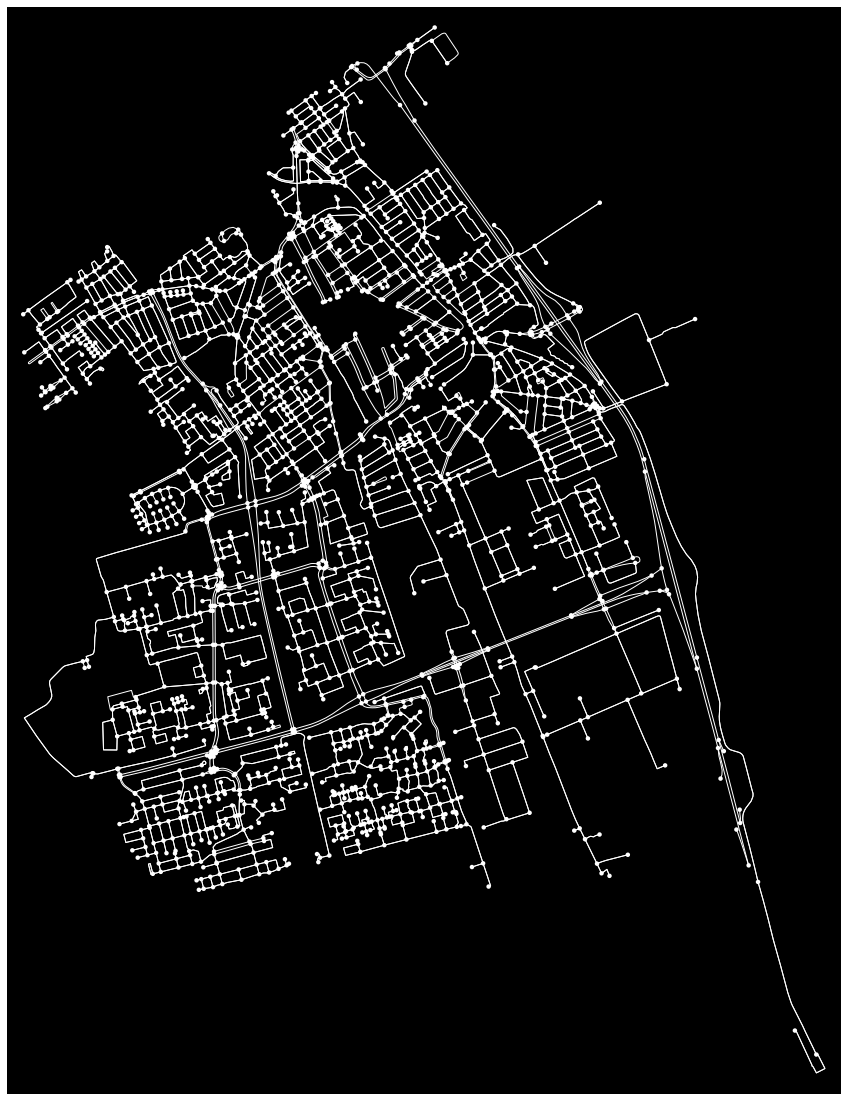

In [131]:
#No need to run
G = sim.inData.G
fig, ax = ox.plot_graph(G, figsize=(20, 20), show=False, close=False, node_size=20, bgcolor='black', edge_color='w')

Number of centeral nodes:  173


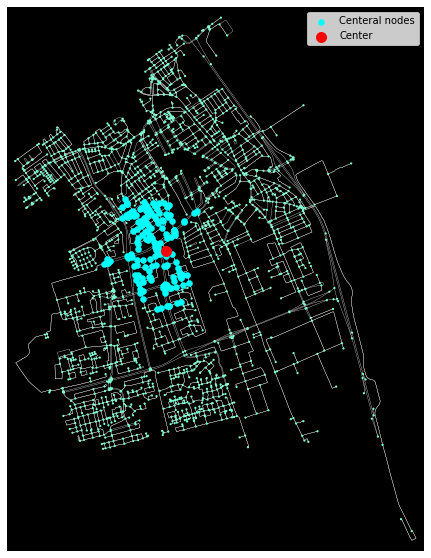

In [7]:
#No need to run
centeral_nodes = sim.inData.stats.central_nodes

l_x=[]
l_y=[]

for i in centeral_nodes:
    l_x.append(sim.inData.G.nodes[i]['x'])
    l_y.append(sim.inData.G.nodes[i]['y'])

print('Number of centeral nodes: ', len(l_x))

fig, ax = ox.plot_graph(sim.inData.G, figsize=(10, 10), node_size=5, edge_linewidth=0.3,
                            show=False, close=False, node_color='aquamarine',
                            edge_color='white', bgcolor='black')

scat = plt.scatter(x=l_x, y=l_y,c='aqua',linewidths=0.5, label='Centeral nodes')
#scat = plt.scatter(x=l_x, y=l_y,c='tab:red',linewidths=1)
scat = plt.scatter(x=sim.inData.G.nodes[sim.inData.stats.center]['x'], 
                   y=sim.inData.G.nodes[sim.inData.stats.center]['y'],c='red',linewidths=5,
                   label='Center')

plt.legend()

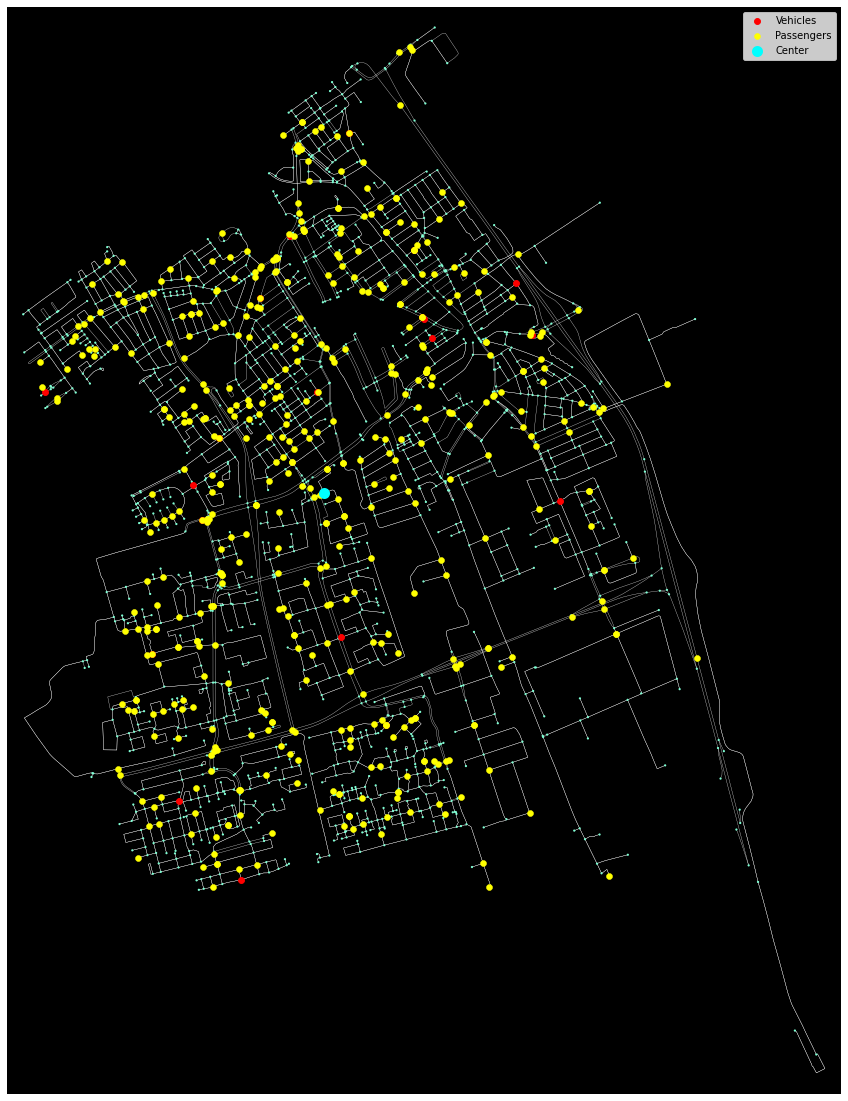

In [25]:
vehicles_position = sim.vehicle_fixed_positions
veh_lx=[]
veh_ly=[]
for i in vehicles_position:
    veh_lx.append(sim.inData.G.nodes[i]['x'])
    veh_ly.append(sim.inData.G.nodes[i]['y'])
    
passengers_position = sim.inData.passengers.pos
pass_lx=[]
pass_ly=[]
for i in passengers_position:
    pass_lx.append(sim.inData.G.nodes[i]['x'])
    pass_ly.append(sim.inData.G.nodes[i]['y'])

fig, ax = ox.plot_graph(sim.inData.G, figsize=(20, 20), node_size=5, edge_linewidth=0.3,
                            show=False, close=False, node_color='aquamarine',
                            edge_color='white', bgcolor='black')

scat = plt.scatter(x=veh_lx, y=veh_ly,c='red',linewidths=0.9, label='Vehicles')
scat = plt.scatter(x=pass_lx, y=pass_ly,c='yellow',linewidths=0.5, label='Passengers')
#scat = plt.scatter(x=l_x, y=l_y,c='tab:red',linewidths=1)
scat = plt.scatter(x=sim.inData.G.nodes[sim.inData.stats.center]['x'], 
                   y=sim.inData.G.nodes[sim.inData.stats.center]['y'],c='aqua',linewidths=5,
                   label='Center')

plt.legend()

In [15]:
r_def= ResultS(sim)

In [16]:
r_def.passengers['waiting_t[sec]'].mean()

206.412

In [125]:
import numpy as np
import pandas as pd
import math
import random as random
from dotmap import DotMap


def f_decline(veh, **kwargs):
    

    df = pd.DataFrame(veh.myrides)
    ASC = 1.5                                                                                   #ASC
    
    working_shift = sim.params.simTime*3600 - veh.veh['shift_start']                               #Time1_loc
    T1 = int(working_shift/3)
    request_time = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']
    
    if  request_time in range(veh.veh['shift_start'], veh.veh['shift_start']+T1):
        Time1 = 1
    else:
        Time1 = 0
        
    if veh.veh['pos'] in sim.inData.stats.central_nodes:
        loc = 1
    else:
        loc = 0
        
        
    d = veh.offers[0]['request']["origin"]                                                       #pickup_time
    o = veh.veh.pos
    pickup_time = veh.sim.skims.ride[o][d]/60  #minutes
      
    t = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']                                        #waiting_time
    
    if 'ARRIVES_AT_DROPOFF' in df['event'].unique():
        t0 = df[df['event']=='ARRIVES_AT_DROPOFF'].iloc[-1]['t']
    else:
        t0 = df[df['event']=='OPENS_APP'].iloc[-1]['t']
    waiting_time = (t - t0)/60 #minutes 
    
    surge_price = 0                                                                               #surge_price
    
    req = 1                         #req                                                          #req_long_rate_dec
    
    if (veh.offers[0]["request"]["dist"]/sim.params.speeds.ride)/60 > 6.5: #long
        long = 1
    else:
        long = 0
        
    rate = sim.pax[veh.offers[0]['pax_id']].pax.get('rate',5)   #rate
    
    if len(veh.declines.index) == 0:          #dec
        last_declined = 'False'
    else:
        last_declined = veh.declines.loc[len(veh.declines.index)-1]['declined']
        
    if last_declined == 'True':
        dec = 1
    else:
        dec = 0
        
           
    V = ((ASC*1) + (Time1*loc*(-0.265)) + (pickup_time*(-0.0491)) + (waiting_time*(-0.0173)) + 
        ((req*long*rate*dec)*0.0909) + (surge_price*0.099))
    
    
    acc_prob = (math.exp(V))/(1+math.exp(V))

    ran =  random.uniform(0, 1)
    if acc_prob > ran:
        a = 'Accepted'
    else:
        a = 'Rejected'
    attr = pd.DataFrame({'pax_id':[veh.offers[0]['pax_id']], 'veh_id':[veh.id], 'Time1':[Time1],  
                         'loc':[loc], 'Time1_loc':[Time1*loc], 'pickup_time':[pickup_time],
                         'waiting_t':[waiting_time], 'surge_price':[surge_price], 'req':1, 'long':long,
                         'rate':rate, 'dec':dec, 'req_long_rate_dec':[req*long*rate*dec*0.091], 
                         'request':a, 'P':[acc_prob]})
    sim.acceptance_attributes = pd.concat([sim.acceptance_attributes,attr])

    
    if acc_prob > ran:
        return False
    else:
        return True
    


sim.make_and_run(f_driver_decline=f_decline)

01-12-21 15:57:22-WARNING-pax    0  got rejected by vehicle 1                2021-12-01 11:42:10
01-12-21 15:57:22-WARNING-Nobody likes each other, Qs 1veh; 1req; tabu 2
01-12-21 15:57:22-WARNING-pax    2  got rejected by vehicle 16               2021-12-01 11:44:00
01-12-21 15:57:23-WARNING-pax   10  got rejected by vehicle 15               2021-12-01 11:47:53
01-12-21 15:57:23-WARNING-pax   10  got rejected by vehicle 8                2021-12-01 11:47:53
01-12-21 15:57:23-WARNING-pax   13  got rejected by vehicle 7                2021-12-01 11:48:21
01-12-21 15:57:23-WARNING-pax   14  got rejected by vehicle 11               2021-12-01 11:48:36
01-12-21 15:57:23-WARNING-pax   18  got rejected by vehicle 11               2021-12-01 11:49:16
01-12-21 15:57:23-WARNING-pax   22  got rejected by vehicle 17               2021-12-01 11:54:13
01-12-21 15:57:23-WARNING-pax   28  got rejected by vehicle 7                2021-12-01 11:59:17
01-12-21 15:57:23-WARNING-pax   48  got rejected by ve

In [126]:
r_homo= ResultS(sim)

In [127]:
r_homo.passengers.mean()['waiting_t[sec]']

219.592

In [128]:
df = r_homo.requests
df['z'] = df['n_of_requests']*df['acceptance_rate %']
ave_p = df['z'].sum()/df['n_of_requests'].sum()/100
ave_p

0.7425595238095238

(-0.025, 0.47)

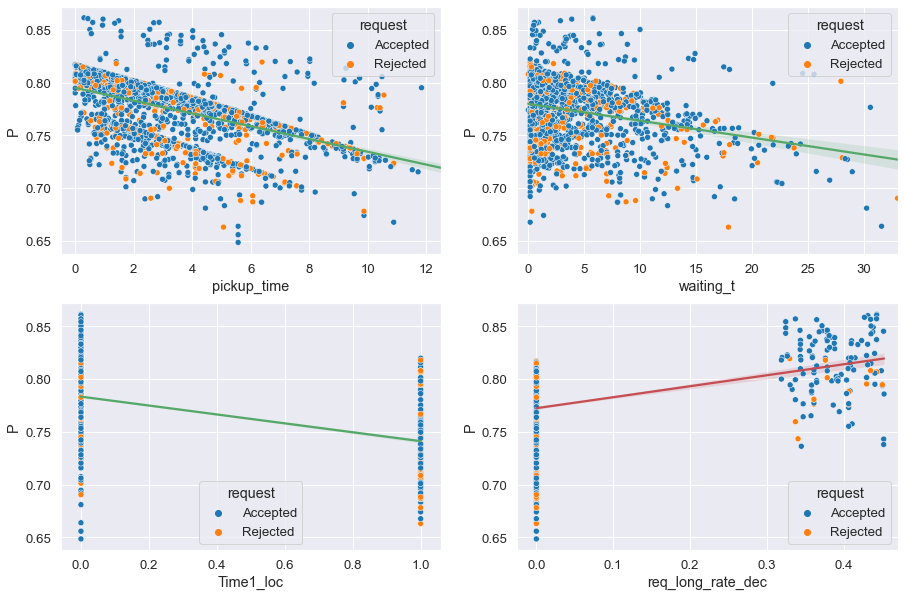

In [171]:
att = sim.acceptance_attributes
att = att[att['pickup_time']<20]
sns.set_style("darkgrid")
sns.set(font_scale = 1.2)
#df['$\delta_t$'] = df['col']
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(15,10))
sns.set_palette('tab10')

sns.regplot(x=att['pickup_time'], y=att['P'], ax= ax[0,0], scatter = False, color='g')
a = sns.scatterplot(x='pickup_time', y='P', data=att, hue='request', ax= ax[0,0])
a.set_xlim(-0.5,12.5)
sns.regplot(x=att['waiting_t'], y=att['P'], ax= ax[0,1], scatter = False, color='g')
b = sns.scatterplot(x='waiting_t', y='P', data=att, hue='request', ax= ax[0,1])
b.set_xlim(-1,33)
sns.regplot(x=att['Time1_loc'], y=att['P'], ax= ax[1,0], scatter = False, color='g')
c = sns.scatterplot(x='Time1_loc', y='P', data=att, hue='request', ax= ax[1,0])
c.set_xlim(-0.06,1.06)
sns.regplot(x=att['req_long_rate_dec'], y=att['P'], color='r', ax= ax[1,1], scatter = False)
d = sns.scatterplot(x='req_long_rate_dec', y='P', data=att, hue='request', ax= ax[1,1])
d.set_xlim(-0.025,0.47)

<AxesSubplot:xlabel='number of declines', ylabel='waiting_t[sec]'>

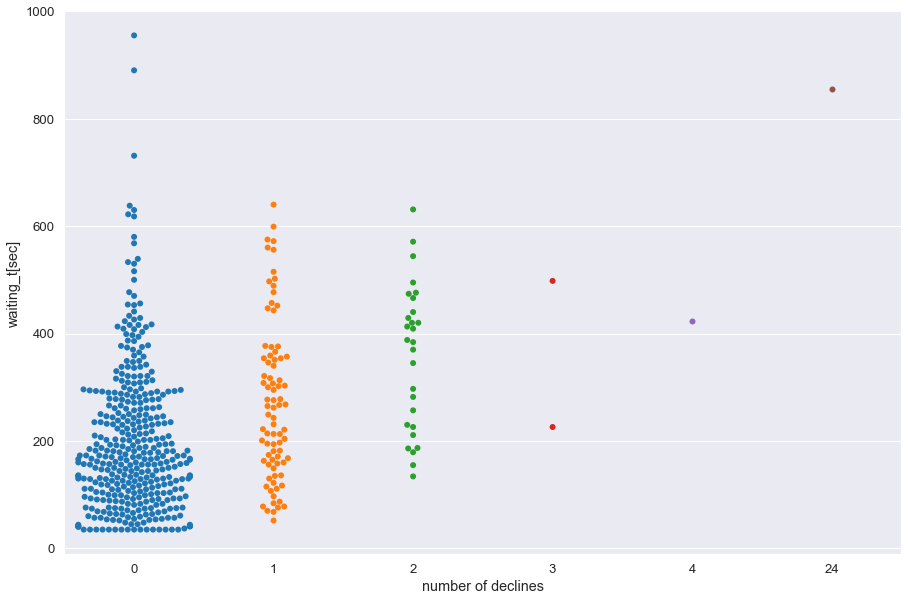

In [158]:
sns.set(font_scale = 1.2)
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(15,10))
sns.set_palette('tab10')

# df = r_homo.passengers
# df['reject_t'] = df['number of declines']*10
# df['waiting_t[sec]'] = df['waiting_t[sec]'] + df['reject_t']

sns.swarmplot(x='number of declines', y='waiting_t[sec]', data=df, size=6)

<AxesSubplot:xlabel='number of declines', ylabel='waiting_t[sec]'>

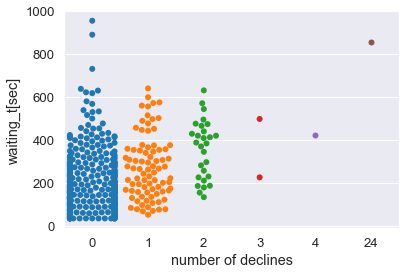

In [159]:
df['$\delta_t$'] = df['col']

sns.swarmplot(x='number of declines', y='waiting_t[sec]', data=df, size=6)

ValueError: Length of values (5) does not match length of index (500)

In [163]:
df.columns

Index(['pax_id', 'veh_id', 'waiting_t[sec]', 'number of declines', 'reject_t'], dtype='object')

In [124]:
a = 5
x = a
x = 6
a
why!!
df = r_homo.passengers
df['reject_t'] = df['number of declines']*10
df['waiting_t[sec]'] = df['waiting_t[sec]'] + df['reject_t']
df

5

In [15]:
d_results = {}

for i in range(1,11):
    
    for p in range(0,110,10):
        
        def f_decline(veh, **kwargs):
    
            if veh.id > 20*p/100: #(sim.params.nV/2):
            #if veh.id < (sim.params.nV/2)+1:
                if random.uniform(0, 1) > ave_p:
                    return True
                else:
                    return False
            else:
                df = pd.DataFrame(veh.myrides)
                ASC = 1.5                                                                                  #ASC

                working_shift = sim.params.simTime*3600 - veh.veh['shift_start']                               #Time1_loc
                T1 = int(working_shift/3)
                request_time = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']

                if  request_time in range(veh.veh['shift_start'], veh.veh['shift_start']+T1):
                    Time1 = 1
                else:
                    Time1 = 0

                if veh.veh['pos'] in sim.inData.stats.central_nodes:
                    loc = 1
                else:
                    loc = 0


                d = veh.offers[0]['request']["origin"]                                                       #pickup_time
                o = veh.veh.pos
                pickup_time = veh.sim.skims.ride[o][d]/60  #minutes

                t = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']                                        #waiting_time

                if 'ARRIVES_AT_DROPOFF' in df['event'].unique():
                    t0 = df[df['event']=='ARRIVES_AT_DROPOFF'].iloc[-1]['t']
                else:
                    t0 = df[df['event']=='OPENS_APP'].iloc[-1]['t']
                waiting_time = (t - t0)/60 #minutes 

                surge_price = 0                                                                               #surge_price

                req = 1                         #req                                                          #req_long_rate_dec

                if (veh.offers[0]["request"]["dist"]/sim.params.speeds.ride)/60 > 6.5: #long
                    long = 1
                else:
                    long = 0

                rate = sim.pax[veh.offers[0]['pax_id']].pax.get('rate',5)   #rate

                if len(veh.declines.index) == 0:          #dec
                    last_declined = 'False'
                else:
                    last_declined = veh.declines.loc[len(veh.declines.index)-1]['declined']

                if last_declined == 'True':
                    dec = 1
                else:
                    dec = 0


                V = ((ASC*1) + (Time1*loc*(-0.265)) + (pickup_time*(-0.0491)) + (waiting_time*(-0.0173)) + 
                    ((req*long*rate*dec)*0.0909) + (surge_price*0.099))


                acc_prob = (math.exp(V))/(1+math.exp(V))

                if acc_prob > random.uniform(0, 1):
                    return False
                else:
                    return True
        
        sim.make_and_run(f_driver_decline=f_decline)
        res= ResultS(sim)
        d_results["sim{sim_n}p{percentage}".format(sim_n=i, percentage=p)] = res


30-11-21 17:43:33-WARNING-pax    4  got rejected by vehicle 10               2021-11-30 15:15:51
30-11-21 17:43:33-WARNING-pax   10  got rejected by vehicle 3                2021-11-30 15:17:42
30-11-21 17:43:33-WARNING-pax   12  got rejected by vehicle 13               2021-11-30 15:18:47
30-11-21 17:43:33-WARNING-pax   29  got rejected by vehicle 12               2021-11-30 15:33:48
30-11-21 17:43:34-WARNING-pax   36  got rejected by vehicle 15               2021-11-30 15:37:54
30-11-21 17:43:34-WARNING-pax   39  got rejected by vehicle 11               2021-11-30 15:39:46
30-11-21 17:43:34-WARNING-pax   40  got rejected by vehicle 15               2021-11-30 15:40:05
30-11-21 17:43:34-WARNING-pax   49  got rejected by vehicle 17               2021-11-30 15:44:58
30-11-21 17:43:34-WARNING-pax   49  got rejected by vehicle 6                2021-11-30 15:44:58
30-11-21 17:43:34-WARNING-pax   56  got rejected by vehicle 10               2021-11-30 15:49:28
30-11-21 17:43:34-WARNING-pax 

In [26]:
d_results['sim3p100'].passengers['waiting_t[sec]'].mean()

211.924

In [27]:
dx = {}
da = {}
for i in range(1,11):
    d_x = {}
    d_a = {}
    for p in range(0,110,10):
        r = d_results['sim{sim_n}p{percentage}'.format(sim_n=i, percentage=p)].trips.groupby(['veh_id']).sum()
        
        rx = r.iloc[0:int(p/100*params.nV)]
        mx = rx['revenue $'].mean()
        d_x["{} %".format(p)] = mx
        
        ra = r.iloc[int(p/100*params.nV):int(params.nV)]
        ma = ra['revenue $'].mean()
        d_a["{} %".format(100-p)] = ma

    dx["sim{}".format(i)] = d_x
    da["sim{}".format(i)] = d_a 

In [361]:
# variation in the revenue of drivers who are employing the acceptance function

xr = pd.DataFrame(dx)
#xr['mean'] = xr.mean(axis=1)
xr

sim1        sim2        sim3        sim4        sim5        sim6  \
0 %           NaN         NaN         NaN         NaN         NaN         NaN   
10 %   153.780000  152.140000  156.710000  159.310000  147.710000  139.980000   
20 %   152.750000  155.445000  144.010000  152.175000  157.710000  146.640000   
30 %   143.666667  147.646667  141.096667  148.366667  149.846667  144.413333   
40 %   146.677500  146.505000  146.967500  144.357500  139.120000  151.312500   
50 %   148.814000  146.846000  148.204000  141.820000  145.462000  147.900000   
60 %   149.423333  148.708333  146.233333  145.090000  144.538333  150.371667   
70 %   144.518571  146.435714  146.257143  146.221429  146.730000  147.830000   
80 %   145.748750  146.971250  145.645000  145.993750  146.287500  148.482500   
90 %   148.346667  142.293333  148.082222  147.292222  148.041111  148.711111   
100 %  143.313000  143.313000  143.313000  143.313000  143.313000  143.313000   

             sim7        sim8        sim9       sim10  
0 %           NaN         NaN         NaN         NaN  
10 %   141.910000  141.710000  163.160000  147.350000  
20 %   147.390000  156.800000  152.525000  147.645000  
30 %   151.600000  145.413333  148.543333  146.260000  
40 %   150.462500  153.180000  148.822500  154.970000  
50 %   143.186000  143.824000  147.220000  143.490000  
60 %   147.428333  148.400000  147.470000  143.741667  
70 %   144.862857  145.698571  147.954286  147.285714  
80 %   145.790000  148.495000  147.887500  146.038750  
90 %   148.515556  148.411111  148.197778  145.936667  
100 %  143.313000  143.313000  143.313000  143.313000

In [362]:
# variation in the revenue of drivers who are not employing the acceptance function

ar = pd.DataFrame(da)
#ar['mean'] = ar.mean(axis=1)
ar

sim1        sim2        sim3        sim4        sim5        sim6  \
100 %  143.993000  143.993000  143.993000  143.993000  143.993000  143.993000   
90 %   142.905556  143.087778  142.580000  142.291111  143.580000  144.438889   
80 %   141.803750  141.130000  143.988750  141.947500  140.563750  143.331250   
70 %   144.132857  142.427143  145.234286  142.118571  141.484286  143.812857   
60 %   142.203333  142.318333  142.010000  143.750000  147.241667  139.113333   
50 %   139.172000  141.140000  139.782000  146.166000  142.524000  140.086000   
40 %   135.847500  136.920000  140.632500  142.347500  143.175000  134.425000   
30 %   142.766667  138.293333  138.710000  138.793333  137.606667  135.040000   
20 %   136.970000  132.080000  137.385000  135.990000  134.815000  126.035000   
10 %   104.810000  152.490000  107.190000  114.300000  107.560000  101.530000   
0 %           NaN         NaN         NaN         NaN         NaN         NaN   

             sim7        sim8        sim9       sim10  
100 %  143.993000  143.993000  143.993000  143.993000  
90 %   144.224444  144.246667  141.863333  143.620000  
80 %   143.143750  140.791250  141.860000  143.080000  
70 %   140.732857  143.384286  142.042857  143.021429  
60 %   139.680000  137.868333  140.773333  136.675000  
50 %   144.800000  144.162000  140.766000  144.496000  
40 %   138.840000  137.382500  138.777500  144.370000  
30 %   141.963333  140.013333  134.750000  136.310000  
20 %   136.805000  125.985000  128.415000  135.810000  
10 %   103.290000  104.230000  106.150000  126.500000  
0 %           NaN         NaN         NaN         NaN

In [363]:
ar = ar.T
xr = xr.T

In [365]:
colsa = [ar[col].squeeze() for col in ar]
colsx = [xr[col].squeeze() for col in xr]

an = pd.concat(colsa, ignore_index=True)
xn = pd.concat(colsx, ignore_index=True)

an = an.to_frame()
an = an.rename(columns = {0:'revenue'})
an['p'] = l

xn = xn.to_frame()
xn = xn.rename(columns = {0:'revenue'})
xn['p'] = l

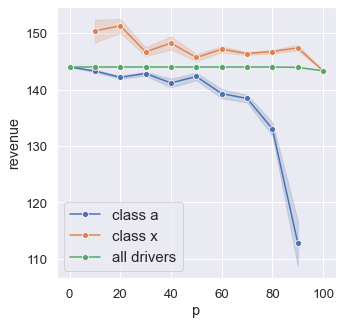

In [366]:
# I need to increase number of simulations to get a better diagram

sns.set(font_scale = 1.2)
fig, ax = plt.subplots(figsize=(5,5))
sns.lineplot(x='p', y='revenue', data=an, marker='o', ci=60)
sns.lineplot(x='p', y='revenue', data=xn, marker='o',ci=60)
sns.lineplot(x='percentage', y='mean', data=tr, marker='o')
plt.legend(labels=["class a","class x", "all drivers"], loc=3, fontsize = 15)

In [174]:
# since we thr trip fare is based on trip distance(oringin to destination) and it does not include pickup
# distance, the total trip fare is almost same for all 110 simulation. If I want this to change I need to 
# add pick time and base fare maybe.

tr = {}

for i in range(1,11):
    d = {}
    for p in range(0,110,10):
        e = d_results['sim{sim_n}p{percentage}'.format(sim_n=i, percentage=p)].trips.groupby(['veh_id']).sum()['revenue $'].mean()
        d["{} %".format(p)] = e
        
    tr["sim{}".format(i)] = d

tr = pd.DataFrame(tr)
tr['mean'] = tr.mean(axis=1)
tr

sim1     sim2     sim3     sim4     sim5     sim6     sim7     sim8  \
0 %    143.993  143.993  143.993  143.993  143.993  143.993  143.993  143.993   
10 %   143.993  143.993  143.993  143.993  143.993  143.993  143.993  143.993   
20 %   143.993  143.993  143.993  143.993  143.993  143.993  143.993  143.993   
30 %   143.993  143.993  143.993  143.993  143.993  143.993  143.993  143.993   
40 %   143.993  143.993  143.993  143.993  143.993  143.993  143.993  143.993   
50 %   143.993  143.993  143.993  143.993  143.993  143.993  143.993  143.993   
60 %   143.993  143.993  143.993  143.993  143.993  143.993  143.993  143.993   
70 %   143.993  143.993  143.993  143.993  143.993  143.993  143.993  143.993   
80 %   143.993  143.993  143.993  143.993  143.993  143.993  143.993  143.993   
90 %   143.993  143.313  143.993  143.993  143.993  143.993  143.993  143.993   
100 %  143.313  143.313  143.313  143.313  143.313  143.313  143.313  143.313   

          sim9    sim10     mean  
0 %    143.993  143.993  143.993  
10 %   143.993  143.993  143.993  
20 %   143.993  143.993  143.993  
30 %   143.993  143.993  143.993  
40 %   143.993  143.993  143.993  
50 %   143.993  143.993  143.993  
60 %   143.993  143.993  143.993  
70 %   143.993  143.993  143.993  
80 %   143.993  143.993  143.993  
90 %   143.993  143.993  143.925  
100 %  143.313  143.313  143.313

In [175]:
tr['percentage'] = [i for i in np.arange(0,110,10)]
tr

sim1     sim2     sim3     sim4     sim5     sim6     sim7     sim8  \
0 %    143.993  143.993  143.993  143.993  143.993  143.993  143.993  143.993   
10 %   143.993  143.993  143.993  143.993  143.993  143.993  143.993  143.993   
20 %   143.993  143.993  143.993  143.993  143.993  143.993  143.993  143.993   
30 %   143.993  143.993  143.993  143.993  143.993  143.993  143.993  143.993   
40 %   143.993  143.993  143.993  143.993  143.993  143.993  143.993  143.993   
50 %   143.993  143.993  143.993  143.993  143.993  143.993  143.993  143.993   
60 %   143.993  143.993  143.993  143.993  143.993  143.993  143.993  143.993   
70 %   143.993  143.993  143.993  143.993  143.993  143.993  143.993  143.993   
80 %   143.993  143.993  143.993  143.993  143.993  143.993  143.993  143.993   
90 %   143.993  143.313  143.993  143.993  143.993  143.993  143.993  143.993   
100 %  143.313  143.313  143.313  143.313  143.313  143.313  143.313  143.313   

          sim9    sim10     mean  percentage  
0 %    143.993  143.993  143.993           0  
10 %   143.993  143.993  143.993          10  
20 %   143.993  143.993  143.993          20  
30 %   143.993  143.993  143.993          30  
40 %   143.993  143.993  143.993          40  
50 %   143.993  143.993  143.993          50  
60 %   143.993  143.993  143.993          60  
70 %   143.993  143.993  143.993          70  
80 %   143.993  143.993  143.993          80  
90 %   143.993  143.993  143.925          90  
100 %  143.313  143.313  143.313         100

In [169]:
d_results['sim1p10'].trips

veh_id  pax_id  pickup_t[min]  pickup_d[km]  travel_t_with[min]  pax_km  \
0        1       0       3.316667          1.99            3.983333    2.39   
1        1      17       2.616667          1.57            5.133333    3.08   
2        1      37       3.016667          1.81            1.766667    1.06   
3        1      52       4.500000          2.70            2.916667    1.75   
4        1      72       2.816667          1.69            3.883333    2.33   
..     ...     ...            ...           ...                 ...     ...   
21      20     422       0.083333          0.05            5.533333    3.32   
22      20     440       0.866667          0.52            2.616667    1.57   
23      20     451       2.883333          1.73            3.033333    1.82   
24      20     457       0.266667          0.16            3.050000    1.83   
25      20     480       2.283333          1.37            8.583333    5.15   

    travel_t[min]  travel_d[km]  veh_waiting_t[sec]  revenue $   p  sim  
0        7.800000          4.68                   0       4.78  10    1  
1        8.250000          4.95                  23       6.16  10    1  
2        5.283333          3.17                  25       2.12  10    1  
3        7.916667          4.75                  34       3.50  10    1  
4        7.200000          4.32                  55       4.66  10    1  
..            ...           ...                 ...        ...  ..  ...  
21       6.116667          3.67                  94       6.64  10    1  
22       3.983333          2.39                 124       3.14  10    1  
23       6.416667          3.85                  36       3.64  10    1  
24       3.816667          2.29                  21       3.66  10    1  
25      11.366667          6.82                 450      10.30  10    1  

[500 rows x 12 columns]

In [179]:
dx = {}
da = {}
for i in range(1,11):
    d_x = {}
    d_a = {}
    for p in range(0,110,10):
        r = d_results['sim{sim_n}p{percentage}'.format(sim_n=i, percentage=p)].passengers
        rx = r; ra = r
        
        rx = rx[rx['veh_id']>0]; rx = rx[rx['veh_id']<int(p/100*params.nV)+1]
        mx = rx['waiting_t[sec]'].mean()
        d_x["{} %".format(p)] = mx
        
        ra = ra[ra['veh_id']>int(p/100*params.nV)]; ra = ra[ra['veh_id']<int(params.nV)+1]
        ma = ra['waiting_t[sec]'].mean()
        d_a["{} %".format(100-p)] = ma

    dx["sim{}".format(i)] = d_x
    da["sim{}".format(i)] = d_a   

In [180]:
# variation in the waiting time of passenger who are being assigned to the drivers employing acceptance function

xw = pd.DataFrame(dx)
#xw['mean'] = xw.mean(axis=1)
xw

sim1        sim2        sim3        sim4        sim5        sim6  \
0 %           NaN         NaN         NaN         NaN         NaN         NaN   
10 %   215.584906  240.019608  182.303571  218.061224  213.180000  263.680851   
20 %   217.485714  206.181818  197.561905  213.057143  217.047619  224.959184   
30 %   229.628378  222.462025  218.106250  218.468354  213.135484  205.943038   
40 %   233.843434  230.787879  239.320000  209.788462  223.308458  220.225962   
50 %   218.720307  228.957198  223.068441  234.040323  225.157692  218.253846   
60 %   223.411765  227.468439  223.689320  226.101911  217.996599  213.444444   
70 %   226.943662  207.667582  224.234286  233.175637  218.850000  215.651685   
80 %   235.332506  225.072816  218.435208  231.921569  219.291971  219.190709   
90 %   235.075431  211.357143  220.536638  231.516340  225.100000  229.069114   
100 %  212.336673  217.264529  215.254509  217.905812  214.442886  207.258517   

             sim7        sim8        sim9       sim10  
0 %           NaN         NaN         NaN         NaN  
10 %   264.043478  208.440000  218.686275  267.509804  
20 %   227.079208  194.962617  226.934579  209.076923  
30 %   207.279503  212.973510  227.040816  203.043210  
40 %   221.729469  216.405660  220.519802  208.034314  
50 %   227.518072  229.149020  228.766129  228.303150  
60 %   225.867742  220.260586  224.062706  230.049505  
70 %   229.831933  229.670391  221.204482  221.837079  
80 %   218.684729  216.723301  220.731707  219.982843  
90 %   220.065076  220.264069  225.642082  225.902386  
100 %  213.637275  217.106212  214.228457  208.993988

In [181]:
# variation in the waiting time of passenger who are being assigned to driver who are not employing 
# the acceptance function

aw = pd.DataFrame(da)
#aw['mean'] = aw.mean(axis=1)
aw

sim1        sim2        sim3        sim4        sim5        sim6  \
100 %  246.900000  253.478000  242.480000  238.030000  241.048000  238.700000   
90 %   243.906040  241.481069  249.565315  239.811530  241.282222  240.000000   
80 %   249.729114  256.628205  249.830380  251.518987  245.832911  247.902985   
70 %   257.417614  251.906433  259.841176  247.757310  252.298551  250.681287   
60 %   259.662252  246.817881  261.010000  263.684932  259.200669  245.832192   
50 %   258.372385  265.259259  274.371308  246.599206  258.254167  262.858333   
40 %   277.376289  270.497487  274.916230  289.919355  248.524272  270.505155   
30 %   294.827586  301.147059  278.526667  298.414966  292.078571  286.472222   
20 %   318.412371  366.761364  338.714286  329.543478  342.000000  332.549451   
10 %   505.916667  199.490196  525.972222  456.097561  492.125000  493.783784   
0 %           NaN         NaN         NaN         NaN         NaN         NaN   

             sim7        sim8        sim9       sim10  
100 %  248.886000  244.104000  236.156000  244.442000  
90 %   244.735683  249.180000  249.786192  252.819599  
80 %   238.932331  251.631043  256.269720  246.022727  
70 %   253.418879  254.776504  251.810198  258.813609  
60 %   259.255973  265.375000  257.140940  243.287162  
50 %   252.023904  257.910204  242.619048  261.280488  
40 %   285.063158  270.658031  279.319797  265.111675  
30 %   296.937063  299.309859  295.475524  294.590278  
20 %   308.404255  331.159091  309.100000  327.065217  
10 %   466.615385  465.789474  493.128205  473.666667  
0 %           NaN         NaN         NaN         NaN

In [182]:
aw = aw.T
xw = xw.T

In [183]:
colsa = [aw[col].squeeze() for col in aw]
colsx = [xw[col].squeeze() for col in xw]

an = pd.concat(colsa, ignore_index=True)
xn = pd.concat(colsx, ignore_index=True)

an = an.to_frame()
an = an.rename(columns = {0:'wait_t'})
an['p'] = l

xn = xn.to_frame()
xn = xn.rename(columns = {0:'wait_t'})
xn['p'] = l

In [143]:
l = []

In [154]:
for i in range(1,11):
    l.append(100)
    
l

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 80,
 80,
 80,
 80,
 80,
 80,
 80,
 80,
 80,
 80,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100]

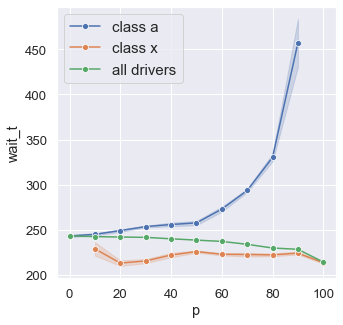

In [197]:
# I need to increase number of simulations to get a better diagram

sns.set(font_scale = 1.2)
fig, ax = plt.subplots(figsize=(5,5))
sns.lineplot(x='p', y='wait_t', data=an, marker='o', ci=60)
sns.lineplot(x='p', y='wait_t', data=xn, marker='o',ci=60)
sns.lineplot(x='percentage', y='mean', data=tw, marker='o')
plt.legend(labels=["class a","class x","all drivers"], loc=2, fontsize = 15)

In [91]:
rx = pd.DataFrame()
ra = pd.DataFrame()

for i in range(1,11):
    r = d_results['sim{sim_n}p50'.format(sim_n=i)].passengers
    rxx = r[r['veh_id']<11]
    raa = r[r['veh_id']>10]
    rx = pd.concat([rx,rxx])
    ra = pd.concat([ra,raa])
    
ra = ra[ra['waiting_t[sec]']<2000]   
rx = rx[rx['waiting_t[sec]']<2000]    

<AxesSubplot:xlabel='pax_id', ylabel='waiting_t[sec]'>

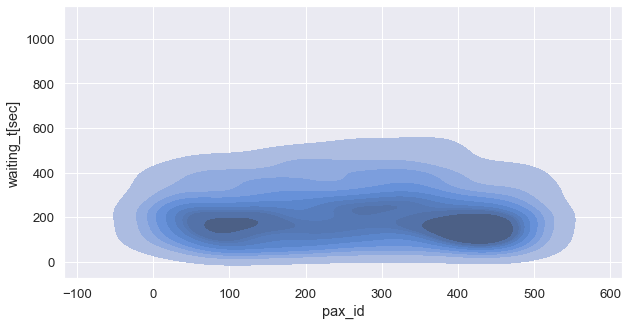

In [96]:
sns.set(font_scale = 1.2)
fig, ax = plt.subplots(figsize=(10,5))

sns.kdeplot(x='pax_id', y='waiting_t[sec]', data=rx, shade=True)
#sns.scatterplot(x='pax_id', y='waiting_t[sec]', data=ra)


In [97]:
rx['class'] = 'class x' 
ra['class'] = 'class a'
rax = pd.concat([ra,rx])

In [100]:
rax['name'] = 'sim5050'

<AxesSubplot:xlabel='name', ylabel='waiting_t[sec]'>

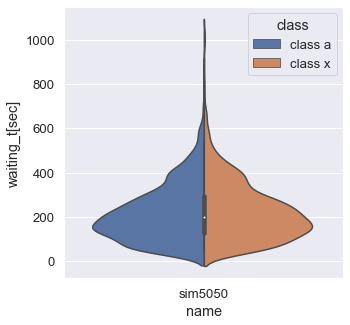

In [104]:
sns.set(font_scale = 1.2)
fig, ax = plt.subplots(figsize=(5,5))

sns.violinplot(x='name', y='waiting_t[sec]', data=rax, hue='class', split=True)

<AxesSubplot:xlabel='name', ylabel='waiting_t[sec]'>

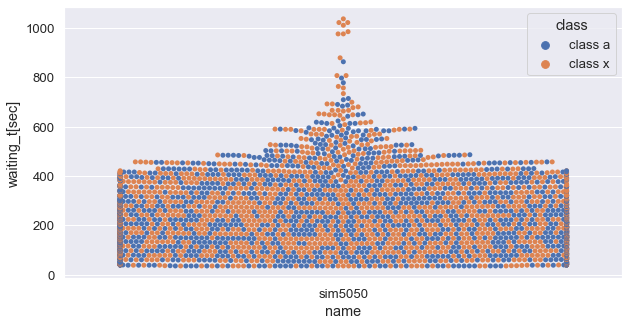

In [111]:
sns.set(font_scale = 1.2)
fig, ax = plt.subplots(figsize=(10,5))

sns.swarmplot(x='name', y='waiting_t[sec]', data=rax, hue='class')

<AxesSubplot:xlabel='waiting_t[sec]', ylabel='Density'>

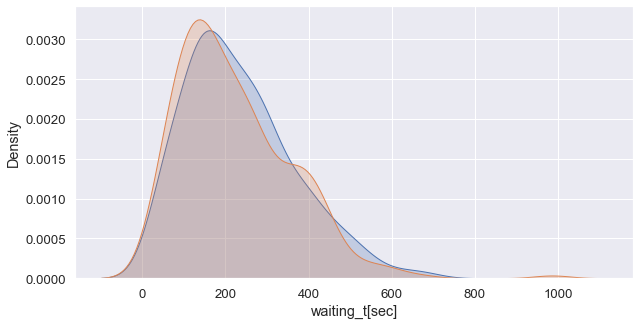

In [126]:
sns.set(font_scale = 1.2)
fig, ax = plt.subplots(figsize=(10,5))

sns.kdeplot(rra['waiting_t[sec]'], shade=True)
sns.kdeplot(rrx['waiting_t[sec]'], shade=True)


In [113]:
r = d_results['sim3p50'].passengers
r = r[r['waiting_t[sec]']<2000]

pax_id  veh_id  waiting_t[sec]  number of declines
0         0     2.0             404                   1
1         1     6.0             269                   1
2         2    14.0              68                   0
3         3    10.0             143                   1
4         4    12.0             147                   2
..      ...     ...             ...                 ...
495     495     4.0             413                   1
496     496     2.0             114                   0
497     497     3.0             208                   0
498     498    20.0             250                   0
499     499    18.0             208                   0

[500 rows x 4 columns]

In [119]:
rrx = r[r['veh_id']<11]
rra = r[r['veh_id']>10]

rrx['class'] = 'class x' 
rra['class'] = 'class a'
rax = pd.concat([rra,rrx])

In [120]:
rax

pax_id  veh_id  waiting_t[sec]  number of declines    class
2         2    14.0              68                   0  class a
4         4    12.0             147                   2  class a
6         6    17.0             136                   0  class a
7         7    16.0              69                   0  class a
10       10    15.0             295                   1  class a
..      ...     ...             ...                 ...      ...
491     491    10.0             113                   0  class x
493     493     9.0             330                   0  class x
495     495     4.0             413                   1  class x
496     496     2.0             114                   0  class x
497     497     3.0             208                   0  class x

[499 rows x 5 columns]

In [185]:
tw = {}

for i in range(1,11):
    d = {}
    for p in range(0,110,10):
        e = d_results['sim{sim_n}p{percentage}'.format(sim_n=i, percentage=p)].passengers['waiting_t[sec]'].mean()
        d["{} %".format(p)] = e
        
    tw["sim{}".format(i)] = d


In [186]:
# Considering the p=0 (no driver is employing acceptance model) & p=100 (all drivers are employing 
# acceptance model) states we can see in general the acceptance function has a positive effect on 
# passengers waiting time. Indeed, the acceptance function is reducing the waiting time when all drivers are
# employing it. Of course it is not pruducing lower waiting times comparing to the state in which all
# driver are accepting all requests.

tw = pd.DataFrame(tw)
tw['mean'] = tw.mean(axis=1)
tw

sim1     sim2     sim3     sim4     sim5     sim6     sim7     sim8  \
0 %    246.900  253.478  242.480  238.030  241.048  238.700  248.886  244.104   
10 %   240.904  241.332  242.032  237.680  238.472  242.226  246.512  245.106   
20 %   242.958  245.530  238.854  243.442  239.788  243.406  236.538  239.504   
30 %   249.192  242.602  246.486  238.502  240.158  236.544  238.562  242.152   
40 %   249.438  240.470  252.334  241.264  244.772  235.180  243.720  244.612   
50 %   237.674  246.600  247.386  240.370  241.044  239.664  239.820  243.242   
60 %   244.350  244.594  243.258  249.842  230.574  235.584  248.362  239.714   
70 %   246.630  233.094  240.522  252.356  239.354  236.048  249.024  249.448   
80 %   251.450  250.010  240.326  249.884  241.134  239.822  235.552  236.864   
90 %   254.576  210.954  242.528  249.932  246.462  248.658  239.296  238.924   
100 %  213.142  218.060  216.054  218.700  215.244  208.074  214.440  217.902   

          sim9    sim10      mean  
0 %    236.156  244.442  243.4224  
10 %   246.614  254.318  243.5196  
20 %   249.992  238.338  241.8350  
30 %   244.528  240.744  241.9470  
40 %   242.346  228.904  242.3040  
50 %   235.748  244.528  241.6076  
60 %   245.834  243.864  242.5976  
70 %   242.446  242.790  243.1712  
80 %   236.638  239.686  242.1366  
90 %   246.506  245.228  242.3064  
100 %  215.030  209.806  214.6452

In [187]:
tw['percentage'] = [i for i in np.arange(0,110,10)]

In [198]:
gini = {}

for n in range(1,11):
    d = {}
    for p in range(0,110,10):
        g = list(d_results['sim{sim_n}p{percentage}'.format(sim_n=n, percentage=p)].trips.groupby(['veh_id']).sum()['revenue $'])
        g.sort()
        s = 0
        for i in range(1,21):
            a = g[i-1]*((20-i+1)+(20-i))/2
            s = s+a
        t = 20*np.sum(g)/2
        gi = (t-s)/t

        d["{} %".format(p)] = gi
        
    gini["sim{}".format(n)] = d


In [199]:
gini = pd.DataFrame(gini)
gini['mean'] = gini.mean(axis=1)
gini

sim1      sim2      sim3      sim4      sim5      sim6      sim7  \
0 %    0.067139  0.056896  0.064081  0.063372  0.054486  0.056630  0.062370   
10 %   0.053243  0.072634  0.066283  0.056432  0.046932  0.056423  0.055865   
20 %   0.081161  0.061630  0.056459  0.064532  0.071126  0.060690  0.061341   
30 %   0.049502  0.064226  0.069504  0.061353  0.070402  0.050298  0.073282   
40 %   0.054520  0.053513  0.064488  0.064085  0.070821  0.065417  0.065463   
50 %   0.069730  0.056160  0.070819  0.058391  0.058262  0.064080  0.054259   
60 %   0.050519  0.055272  0.056923  0.054461  0.060511  0.067015  0.054336   
70 %   0.049338  0.047733  0.071423  0.065310  0.060523  0.054766  0.052061   
80 %   0.063505  0.089550  0.063224  0.055177  0.066259  0.070962  0.065995   
90 %   0.069406  0.044526  0.057655  0.079233  0.067824  0.065583  0.065931   
100 %  0.047528  0.037287  0.052283  0.053476  0.045691  0.034385  0.034046   

           sim8      sim9     sim10      mean  
0 %    0.047714  0.056641  0.058605  0.058793  
10 %   0.053225  0.060171  0.053936  0.057514  
20 %   0.066726  0.063149  0.057805  0.064462  
30 %   0.051688  0.063707  0.069853  0.062381  
40 %   0.070640  0.061297  0.067015  0.063726  
50 %   0.058748  0.069605  0.067061  0.062712  
60 %   0.064118  0.062584  0.063806  0.058954  
70 %   0.061163  0.050222  0.067861  0.058040  
80 %   0.045184  0.060266  0.058957  0.063908  
90 %   0.076954  0.058352  0.067570  0.065303  
100 %  0.034491  0.048352  0.049752  0.043729

<AxesSubplot:xlabel='percentage', ylabel='mean'>

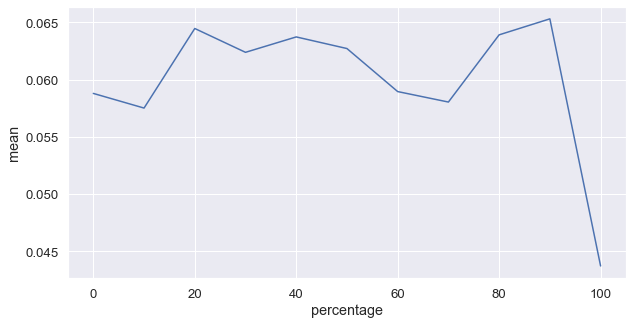

In [200]:
gini['percentage'] = [i for i in np.arange(0,110,10)]

fig, ax = plt.subplots(figsize=(10,5))

sns.lineplot(x='percentage', y='mean', data=gini, ci=0)

In [251]:
dx = pd.DataFrame()
xd = pd.DataFrame()
for i in range(1,11):
    d = d_results['sim{}p100'.format(i)].trips.groupby(['veh_id']).sum()
    f = d_results['sim{}p100'.format(i)].requests
    dx = pd.concat([dx,d])
    xd = pd.concat([xd,f])

xd.reset_index(inplace=True)
dx.reset_index(inplace=True)    

da = pd.DataFrame()
ad = pd.DataFrame()
for i in range(1,11):
    d = d_results['sim{}p0'.format(i)].trips.groupby(['veh_id']).sum()
    f = d_results['sim{}p0'.format(i)].requests
    da = pd.concat([da,d])
    ad = pd.concat([ad,f])
    
ad.reset_index(inplace=True)
da.reset_index(inplace=True)

In [252]:
dx['rate'] = xd['acceptance_rate %']
dx['class'] = 'class x'
da['rate'] = ad['acceptance_rate %']
da['class'] = 'class a'

dh = pd.concat([da,dx])
dh.reset_index(inplace=True)

In [253]:
dh

index  veh_id  pax_id  pickup_t[min]  pickup_d[km]  travel_t_with[min]  \
0        0       1    7045      89.416667         53.65          114.566667   
1        1       2    5447      81.850000         49.11          120.650000   
2        2       3    8535      82.316667         49.39          128.666667   
3        3       4    6186      74.583333         44.75          100.566667   
4        4       5    5326      71.766667         43.06          110.233333   
..     ...     ...     ...            ...           ...                 ...   
395    195      16    6769      68.450000         41.07          126.600000   
396    196      17    7027      76.816667         46.09          129.150000   
397    197      18    6009      70.433333         42.26          118.766667   
398    198      19    6417      70.550000         42.33          100.300000   
399    199      20    6524      76.333333         45.80          135.966667   

     pax_km  travel_t[min]  travel_d[km]  veh_waiting_t[sec]  revenue $     p  \
0     68.74     218.483333        131.09                3591     137.48     0   
1     72.39     214.000000        128.40                4180     144.78     0   
2     77.20     226.566667        135.94                3971     154.40     0   
3     60.34     187.150000        112.29                5845     120.68     0   
4     66.14     192.500000        115.50                5628     132.28     0   
..      ...            ...           ...                 ...        ...   ...   
395   75.96     208.550000        125.13                4352     151.92  2700   
396   77.49     218.966667        131.38                3993     154.98  2600   
397   71.26     202.316667        121.39                4743     142.52  2600   
398   60.18     183.683333        110.21                5829     120.36  2500   
399   81.58     226.933333        136.16                3735     163.16  2900   

     sim       rate    class  
0     29  80.555556  class a  
1     23  62.162162  class a  
2     31  73.809524  class a  
3     24  70.588235  class a  
4     21  75.000000  class a  
..   ...        ...      ...  
395  270  72.972973  class x  
396  260  86.666667  class x  
397  260  76.470588  class x  
398  250  73.529412  class x  
399  290  74.358974  class x  

[400 rows x 15 columns]

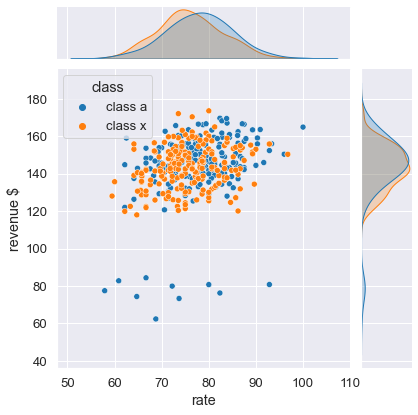

In [264]:
sns.set(font_scale = 1.2)

sns.jointplot(x='rate', y='revenue $', data=dh, hue='class', palette='tab10')

<AxesSubplot:xlabel='rate', ylabel='revenue $'>

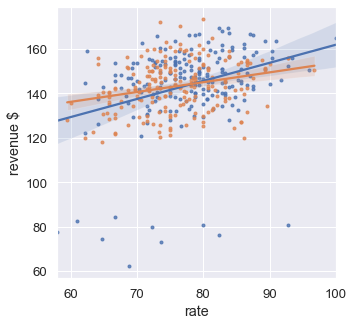

In [276]:
sns.set(font_scale = 1.2)
fig, ax = plt.subplots(figsize=(5,5))


sns.regplot(x='rate', y='revenue $', data=da, marker='.')
sns.regplot(x='rate', y='revenue $', data=dx, marker='.')

<AxesSubplot:xlabel='class', ylabel='revenue $'>

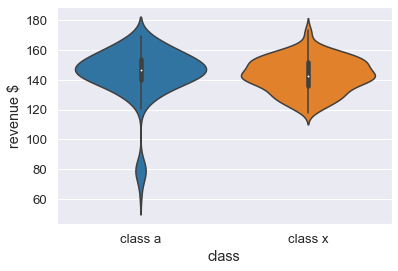

In [295]:
sns.violinplot(x='class', y='revenue $', data=dh, palette='tab10')

In [54]:
d_def = {}
    
for i in range(1,2):
        
    def f_decline(veh, **kwargs):
        if True:
            return False
        else:
            return True
    sim.make_and_run(f_driver_decline=f_decline)
    resD= ResultS(sim)
    d_def["sim{sim_n}def".format(sim_n=i)] = resD
    
resD.passengers['waiting_t[sec]'].mean()

30-11-21 23:26:43-WARNING-simulation time 8.8 s
30-11-21 23:26:43-WARNING-assertion tests for simulation results - passed


201.496

In [81]:
d_ave_p = {}
    
for i in range(1,2):
        
    def f_decline(veh, **kwargs):
        if random.uniform(0, 1) > ave_p:
            return True
        else:
            return False
    sim.make_and_run(f_driver_decline=f_decline)
    resA= ResultS(sim)
    d_ave_p["sim{sim_n}ave".format(sim_n=i)] = resA
    
resA.passengers['waiting_t[sec]'].mean()

30-11-21 23:36:00-WARNING-pax    4  got rejected by vehicle 2                2021-11-30 21:06:03
30-11-21 23:36:00-WARNING-pax   11  got rejected by vehicle 17               2021-11-30 21:11:04
30-11-21 23:36:00-WARNING-pax   15  got rejected by vehicle 20               2021-11-30 21:11:47
30-11-21 23:36:00-WARNING-pax   21  got rejected by vehicle 17               2021-11-30 21:15:10
30-11-21 23:36:00-WARNING-pax   21  got rejected by vehicle 16               2021-11-30 21:15:10
30-11-21 23:36:00-WARNING-pax   22  got rejected by vehicle 17               2021-11-30 21:17:21
30-11-21 23:36:00-WARNING-pax   27  got rejected by vehicle 17               2021-11-30 21:20:23
30-11-21 23:36:00-WARNING-pax   33  got rejected by vehicle 2                2021-11-30 21:24:21
30-11-21 23:36:00-WARNING-pax   36  got rejected by vehicle 7                2021-11-30 21:25:45
30-11-21 23:36:01-WARNING-pax   53  got rejected by vehicle 17               2021-11-30 21:39:48
30-11-21 23:36:01-WARNING-pax 

315.062

In [62]:
d_accep_model = {}

for i in range(1,2):
        
    def f_decline(veh, **kwargs):

        df = pd.DataFrame(veh.myrides)
        ASC = 1.5                                                                                   #ASC

        working_shift = sim.params.simTime*3600 - veh.veh['shift_start']                               #Time1_loc
        T1 = int(working_shift/3)
        request_time = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']

        if  request_time in range(veh.veh['shift_start'], veh.veh['shift_start']+T1):
            Time1 = 1
        else:
            Time1 = 0

        if veh.veh['pos'] in sim.inData.stats.central_nodes:
            loc = 1
        else:
            loc = 0


        d = veh.offers[0]['request']["origin"]                                                       #pickup_time
        o = veh.veh.pos
        pickup_time = veh.sim.skims.ride[o][d]/60  #minutes

        t = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']                                        #waiting_time

        if 'ARRIVES_AT_DROPOFF' in df['event'].unique():
            t0 = df[df['event']=='ARRIVES_AT_DROPOFF'].iloc[-1]['t']
        else:
            t0 = df[df['event']=='OPENS_APP'].iloc[-1]['t']
        waiting_time = (t - t0)/60 #minutes 

        surge_price = 0                                                                               #surge_price

        req = 1                         #req                                                          #req_long_rate_dec

        if (veh.offers[0]["request"]["dist"]/sim.params.speeds.ride)/60 > 6.5: #long
            long = 1
        else:
            long = 0

        rate = sim.pax[veh.offers[0]['pax_id']].pax.get('rate',5)   #rate

        if len(veh.declines.index) == 0:          #dec
            last_declined = 'False'
        else:
            last_declined = veh.declines.loc[len(veh.declines.index)-1]['declined']

        if last_declined == 'True':
            dec = 1
        else:
            dec = 0


        V = ((ASC*1) + (Time1*loc*(-0.265)) + (pickup_time*(-0.0491)) + (waiting_time*(-0.0173)) + 
            ((req*long*rate*dec)*0.0909) + (surge_price*0.099))


        acc_prob = (math.exp(V))/(1+math.exp(V))

        if acc_prob > random.uniform(0, 1):
            return False
        else:
            return True
                
    sim.make_and_run(f_drivd_a_decline=f_decline)
    resX= ResultS(sim)
    d_accep_model["sim{sim_n}accep".format(sim_n=i)] = resX

resX.passengers['waiting_t[sec]'].mean()

30-11-21 23:30:10-WARNING-simulation time 8.6 s
30-11-21 23:30:11-WARNING-assertion tests for simulation results - passed


240.032

In [33]:
df = pd.DataFrame()
for i in range(1,11):
    d = d_def["sim{sim_n}def".format(sim_n=i)]
    df = pd.concat([df,d.passengers])
df = df[df['waiting_t[sec]']<2000]

da = pd.DataFrame()
for i in range(1,11):
    d = d_ave_p["sim{sim_n}ave".format(sim_n=i)]
    da = pd.concat([da,d.passengers])
da = da[da['waiting_t[sec]']<2000]
    
dx = pd.DataFrame()
for i in range(1,11):
    d = d_accep_model["sim{sim_n}accep".format(sim_n=i)]
    dx = pd.concat([dx,d.passengers])
dx = dx[dx['waiting_t[sec]']<2000]


KeyError: 'sim2def'

In [385]:
df.reset_index(inplace=True)
df['class'] ='class d' 

da.reset_index(inplace=True)
da['class'] ='class a'

dx.reset_index(inplace=True)
dx['class'] ='class x'

dax = pd.concat([df,da,dx])

<AxesSubplot:xlabel='class', ylabel='waiting_t[sec]'>

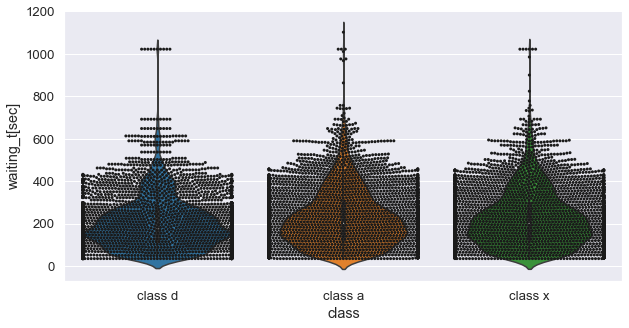

In [386]:
sns.set(font_scale = 1.2)
fig, ax = plt.subplots(figsize=(10,5))


sns.violinplot(x='class', y='waiting_t[sec]', data=dax, palette='tab10')
sns.swarmplot(x='class', y='waiting_t[sec]', color='k', size=3, data=dax)

<AxesSubplot:xlabel='waiting_t[sec]', ylabel='Density'>

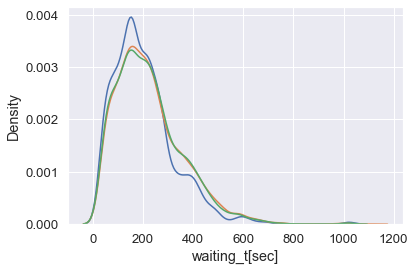

In [392]:
sns.kdeplot(x='waiting_t[sec]', data=df, palette='tab10')
sns.kdeplot(x='waiting_t[sec]', data=da, palette='tab10')
sns.kdeplot(x='waiting_t[sec]', data=dx, palette='tab10')


In [17]:
df = pd.DataFrame()
for i in range(1,11):
    d = d_def["sim{sim_n}def".format(sim_n=i)]
    df = pd.concat([df,d.trips.groupby(['veh_id']).sum()])

da = pd.DataFrame()
for i in range(1,11):
    d = d_ave_p["sim{sim_n}ave".format(sim_n=i)]
    da = pd.concat([da,d.trips.groupby(['veh_id']).sum()])
    
dx = pd.DataFrame()
for i in range(1,11):
    d = d_accep_model["sim{sim_n}accep".format(sim_n=i)]
    dx = pd.concat([dx,d.trips.groupby(['veh_id']).sum()])

df.reset_index(inplace=True)
df['class'] ='class d' 

da.reset_index(inplace=True)
da['class'] ='class a'

dx.reset_index(inplace=True)
dx['class'] ='class x'

dax = pd.concat([df,da,dx])

KeyError: 'sim2def'

<AxesSubplot:xlabel='class', ylabel='revenue $'>

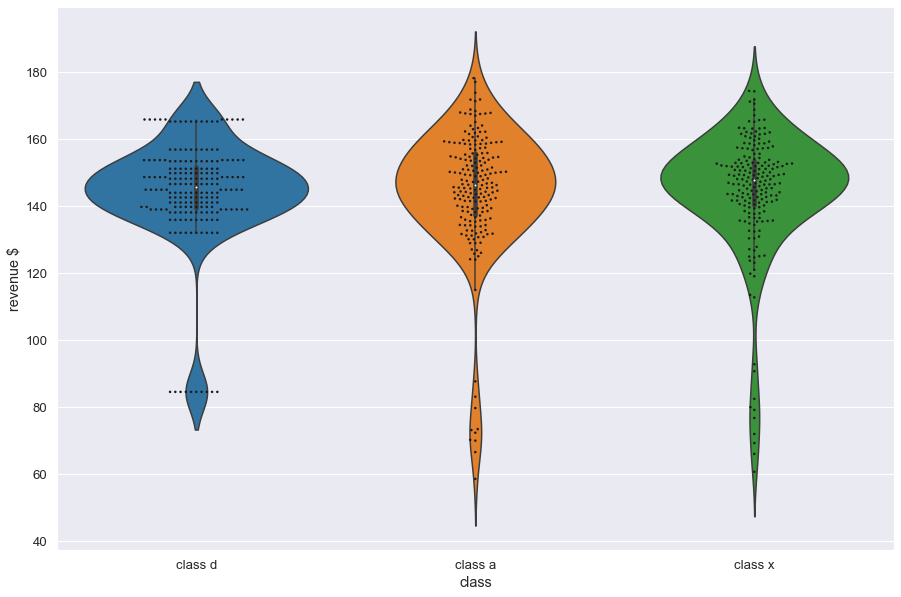

In [382]:
sns.set(font_scale = 1.2)
fig, ax = plt.subplots(figsize=(15,10))


sns.swarmplot(x='class', y='revenue $', color='k', data=dax, marker='.')
sns.violinplot(x='class', y='revenue $', data=dax,palette='tab10')

In [347]:
dax[dax['revenue $']<70]

veh_id  pax_id  pickup_t[min]  pickup_d[km]  travel_t_with[min]  pax_km  \
49       10    1341     205.900000        123.54           55.400000   33.24   
67        8    1286     195.783333        117.47           58.250000   34.95   
124       5    1481     197.866667        118.72           48.733333   29.24   
30       11    1508     205.433333        123.26           57.650000   34.59   
168       9    1704     204.233333        122.54           50.516667   30.31   
189      10    1408     192.950000        115.77           54.950000   32.97   

     travel_t[min]  travel_d[km]  veh_waiting_t[sec]  revenue $    class  
49      266.300000        159.78                2964      66.48  class a  
67      259.033333        155.42                3400      69.90  class a  
124     252.100000        151.26                3796      58.48  class a  
30      269.083333        161.45                2757      69.18  class x  
168     260.766667        156.46                3226      60.62  class x  
189     253.400000        152.04                3718      65.94  class x

In [356]:
def gini(x):
    g = list(x)
    g.sort()
    s = 0
    for i in range(1,21):
        a = g[i-1]*((20-i+1)+(20-i))/2
        s = s+a
    t = 20*np.sum(g)/2
    gi = (t-s)/t
    return gi

In [358]:
print('gini coefficient for df is {}, for da is {} and for dx is {}'.format(gini(df['revenue $']), 
                                                                            gini(da['revenue $']), 
                                                                            gini(dx['revenue $'])))

gini coefficient for df is 0.9330974422367754, for da is 0.9411260616835541 and for dx is 0.9403602952921322


In [ ]:
=========================================================================

In [90]:
d = resD.trips.groupby(['veh_id']).sum()
d['class'] ='D'

a = resA.trips.groupby(['veh_id']).sum()
a['class'] ='A' 

x = resX.trips.groupby(['veh_id']).sum()
x['class'] ='X' 

dax = pd.concat([d,a,x])
#dax

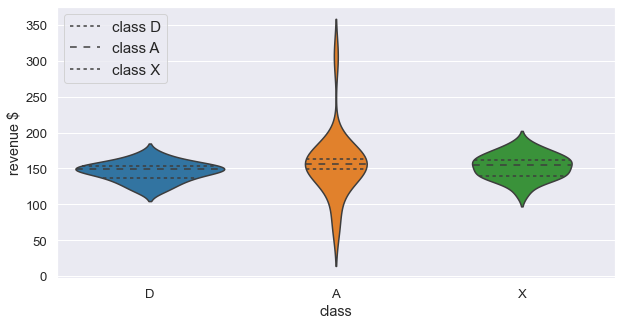

In [92]:
sns.set(font_scale = 1.2)
fig, ax = plt.subplots(figsize=(10,5))


sns.violinplot(x='class', y='revenue $', data=dax,inner='quartile', palette='tab10', scale='area', bw='silverman')
plt.legend(labels=["class D","class A", "class X"], loc=2, fontsize = 15)

<AxesSubplot:xlabel='revenue $', ylabel='Density'>

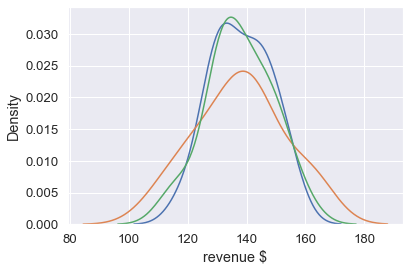

In [37]:
sns.kdeplot(x = 'revenue $', data=d)
sns.kdeplot(x = 'revenue $', data=a)
sns.kdeplot(x = 'revenue $', data=x)

In [93]:
d = resD.passengers
d = d[d['waiting_t[sec]']<2000]
d['class'] ='D'

a = resA.passengers
a = a[a['waiting_t[sec]']<2000]
a['class'] ='A'

x = resX.passengers
x = x[x['waiting_t[sec]']<2000]
x['class'] ='X' 

dax = pd.concat([d,a,x])
daxp = pd.concat([d,a,x])
#dax

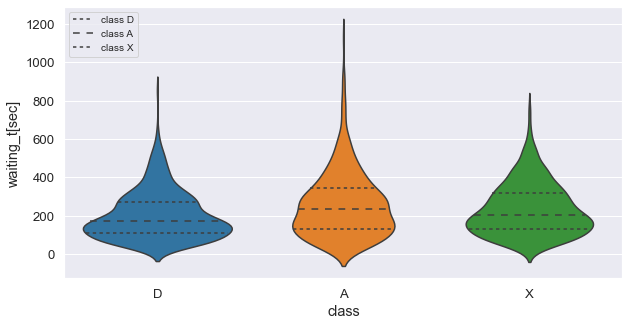

In [95]:
sns.set(font_scale = 1.2)
fig, ax = plt.subplots(figsize=(10,5))


sns.violinplot(x='class', y='waiting_t[sec]', data=dax, inner='quartile', palette='tab10')
plt.legend(labels=["class D","class A", "class X"], loc=2, fontsize = 10)

<AxesSubplot:xlabel='waiting_t[sec]', ylabel='Density'>

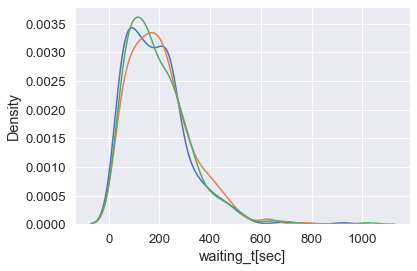

In [61]:
sns.kdeplot(x = 'waiting_t[sec]', data=d)
sns.kdeplot(x = 'waiting_t[sec]', data=a)
sns.kdeplot(x = 'waiting_t[sec]', data=x)

In [66]:
resD.passengers['waiting_t[sec]'].mean()

201.496

In [82]:
resA.passengers['waiting_t[sec]'].mean()

315.062

In [68]:
resX.passengers['waiting_t[sec]'].mean()

232.89

In [88]:
d = resD.trips.groupby(['veh_id']).sum()
d['class'] ='D'

a = resA.trips.groupby(['veh_id']).sum()
a['class'] ='A' 

x = resX.trips.groupby(['veh_id']).sum()
x['class'] ='X' 

dax = pd.concat([d,a,x])
daxv = pd.concat([d,a,x])

#dax

<AxesSubplot:xlabel='class', ylabel='veh_waiting_t[sec]'>

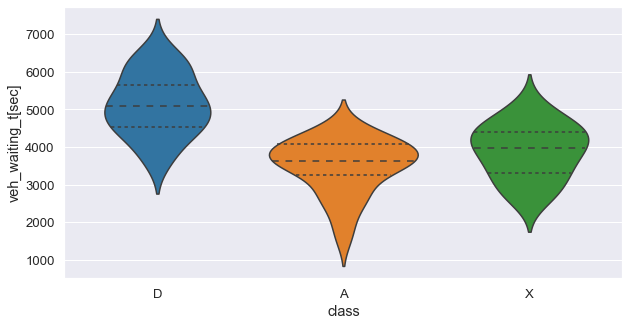

In [89]:
sns.set(font_scale = 1.2)
fig, ax = plt.subplots(figsize=(10,5))


sns.violinplot(x='class', y='veh_waiting_t[sec]', data=dax,inner='quartile', palette='tab10')

In [26]:
resX.requests['n_of_declined'].sum()

156

In [ ]:
====================================================================================

In [48]:
Dd = pd.DataFrame()
Ad = pd.DataFrame()
Xd = pd.DataFrame()

Dp = pd.DataFrame()
Ap = pd.DataFrame()
Xp = pd.DataFrame()


for i in range(1,11):
    sim= MaaSSim.simulators.simulate(params=params, logger_level=logging.WARNING)
    
    def f_decline(veh, **kwargs):
        if True:
            return False
        else:
            return True
    sim.make_and_run(f_driver_decline=f_decline)
    resD= ResultS(sim)
    
    def f_decline(veh, **kwargs):
        if random.uniform(0, 1) > ave_p:
            return True
        else:
            return False
    sim.make_and_run(f_driver_decline=f_decline)
    resA= ResultS(sim)
    
    def f_decline(veh, **kwargs):

        df = pd.DataFrame(veh.myrides)
        ASC = 1.5                                                                                   #ASC

        working_shift = sim.params.simTime*3600 - veh.veh['shift_start']                               #Time1_loc
        T1 = int(working_shift/3)
        request_time = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']

        if  request_time in range(veh.veh['shift_start'], veh.veh['shift_start']+T1):
            Time1 = 1
        else:
            Time1 = 0

        if veh.veh['pos'] in sim.inData.stats.central_nodes:
            loc = 1
        else:
            loc = 0


        d = veh.offers[0]['request']["origin"]                                                       #pickup_time
        o = veh.veh.pos
        pickup_time = veh.sim.skims.ride[o][d]/60  #minutes

        t = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']                                        #waiting_time

        if 'ARRIVES_AT_DROPOFF' in df['event'].unique():
            t0 = df[df['event']=='ARRIVES_AT_DROPOFF'].iloc[-1]['t']
        else:
            t0 = df[df['event']=='OPENS_APP'].iloc[-1]['t']
        waiting_time = (t - t0)/60 #minutes 

        surge_price = 0                                                                               #surge_price

        req = 1                         #req                                                          #req_long_rate_dec

        if (veh.offers[0]["request"]["dist"]/sim.params.speeds.ride)/60 > 6.5: #long
            long = 1
        else:
            long = 0

        rate = sim.pax[veh.offers[0]['pax_id']].pax.get('rate',5)   #rate

        if len(veh.declines.index) == 0:          #dec
            last_declined = 'False'
        else:
            last_declined = veh.declines.loc[len(veh.declines.index)-1]['declined']

        if last_declined == 'True':
            dec = 1
        else:
            dec = 0


        V = ((ASC*1) + (Time1*loc*(-0.265)) + (pickup_time*(-0.0491)) + (waiting_time*(-0.0173)) + 
            ((req*long*rate*dec)*0.0909) + (surge_price*0.099))


        acc_prob = (math.exp(V))/(1+math.exp(V))

        if acc_prob > random.uniform(0, 1):
            return False
        else:
            return True     
    sim.make_and_run(f_drivd_a_decline=f_decline)
    resX= ResultS(sim)
    
    Dd = pd.concat([Dd,resD.trips.groupby(['veh_id']).sum()])
    Ad = pd.concat([Ad,resA.trips.groupby(['veh_id']).sum()])
    Xd = pd.concat([Xd,resX.trips.groupby(['veh_id']).sum()])
    
    Dp = pd.concat([Dp,resD.passengers])
    Ap = pd.concat([Ap,resA.passengers])
    Xp = pd.concat([Xp,resX.passengers])


30-11-21 22:52:03-WARNING-Setting up 5h simulation at 2021-11-30 20:22:05 for 20 vehicles and 500 passengers in Delft, Netherlands
30-11-21 22:52:12-WARNING-simulation time 8.8 s
30-11-21 22:52:12-WARNING-assertion tests for simulation results - passed
30-11-21 22:52:21-WARNING-simulation time 8.5 s
30-11-21 22:52:22-WARNING-assertion tests for simulation results - passed
30-11-21 22:52:23-WARNING-pax    2  got rejected by vehicle 15               2021-11-30 20:23:13
30-11-21 22:52:24-WARNING-pax    8  got rejected by vehicle 14               2021-11-30 20:27:31
30-11-21 22:52:24-WARNING-pax   15  got rejected by vehicle 16               2021-11-30 20:32:09
30-11-21 22:52:24-WARNING-pax   15  got rejected by vehicle 6                2021-11-30 20:32:09
30-11-21 22:52:24-WARNING-pax   16  got rejected by vehicle 6                2021-11-30 20:32:36
30-11-21 22:52:24-WARNING-pax   31  got rejected by vehicle 11               2021-11-30 20:39:25
30-11-21 22:52:24-WARNING-pax   32  got rej

In [54]:
Dd['class'] = 'D'
Ad['class'] = 'A'
Xd['class'] = 'X'
DAX = pd.concat([Dd,Ad,Xd])
DAX

pax_id  pickup_t[min]  pickup_d[km]  travel_t_with[min]  pax_km  \
veh_id                                                                    
1         7084      70.816667         42.49          116.633333   69.98   
2         6083      74.033333         44.42          110.266667   66.16   
3         5284      63.566667         38.14           91.866667   55.12   
4         6793      70.750000         42.45          113.283333   67.97   
5         6499      55.950000         33.57          132.066667   79.24   
...        ...            ...           ...                 ...     ...   
16        6876      64.216667         38.53          115.333333   69.20   
17        6472      70.650000         42.39          121.166667   72.70   
18        7733      83.300000         49.98          130.600000   78.36   
19        5896      73.516667         44.11          109.316667   65.59   
20        6157      82.250000         49.35          104.850000   62.91   

        travel_t[min]  travel_d[km]  veh_waiting_t[sec]  revenue $ class  
veh_id                                                                    
1          202.066667        121.24                5260     139.96     D  
2          196.800000        118.08                5616     132.32     D  
3          166.433333         99.86                5313     110.24     D  
4          197.950000        118.77                5315     135.94     D  
5          200.033333        120.02                5683     158.48     D  
...               ...           ...                 ...        ...   ...  
16         192.550000        115.53                5660     138.40     X  
17         205.166667        123.10                4982     145.40     X  
18         228.883333        137.33                3981     156.72     X  
19         194.833333        116.90                5614     131.18     X  
20         199.400000        119.64                5961     125.82     X  

[600 rows x 10 columns]

<AxesSubplot:xlabel='veh_waiting_t[sec]', ylabel='Density'>

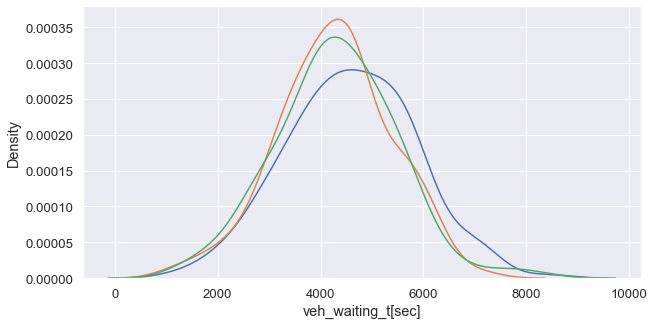

In [53]:
sns.set(font_scale = 1.2)
fig, ax = plt.subplots(figsize=(10,5))

sns.kdeplot(x = 'veh_waiting_t[sec]', data=Dd)
sns.kdeplot(x = 'veh_waiting_t[sec]', data=Ad)
sns.kdeplot(x = 'veh_waiting_t[sec]', data=Xd)

In [149]:
df = pd.DataFrame(d_f)
df['mean'] = df.mean(axis=1)
df

sim1        sim2        sim3        sim4        sim5        sim6  \
0 %           NaN         NaN         NaN         NaN         NaN         NaN   
10 %   142.070000  145.410000  146.560000  141.330000  144.360000  136.070000   
20 %   145.025000  142.475000  140.060000  151.135000  142.345000  144.650000   
30 %   137.746667  143.066667  147.310000  147.046667  144.513333  150.600000   
40 %   138.705000  144.745000  148.617500  146.005000  142.077500  141.515000   
50 %   144.464000  146.142000  142.886000  142.240000  144.462000  147.564000   
60 %   147.096667  142.991667  143.946667  141.571667  143.715000  142.120000   
70 %   143.470000  144.110000  144.138571  143.908571  140.965714  142.574286   
80 %   146.595000  144.885000  144.781250  145.445000  145.078750  144.288750   
90 %   144.534444  143.148889  143.437778  143.528889  144.401111  143.288889   
100 %  140.342000  140.622000  141.455000  141.002000  141.124000  141.075000   

             sim7        sim8        sim9       sim10        mean  
0 %           NaN         NaN         NaN         NaN         NaN  
10 %   144.290000  143.770000  136.030000  149.210000  142.910000  
20 %   148.830000  142.550000  150.110000  150.470000  145.765000  
30 %   137.056667  147.033333  149.746667  146.950000  145.107000  
40 %   146.312500  144.607500  142.837500  138.270000  143.369250  
50 %   143.108000  140.766000  143.242000  146.334000  144.120800  
60 %   140.570000  143.496667  145.431667  143.286667  143.422667  
70 %   140.901429  144.958571  142.922857  143.304286  143.125429  
80 %   144.166250  145.425000  143.325000  144.765000  144.875500  
90 %   144.763333  142.562222  141.307778  144.794444  143.576778  
100 %  141.138000  141.477000  141.124000  140.220000  140.957900

In [150]:
df['percentage'] = [i for i in np.arange(0,110,10)]
df

sim1        sim2        sim3        sim4        sim5        sim6  \
0 %           NaN         NaN         NaN         NaN         NaN         NaN   
10 %   142.070000  145.410000  146.560000  141.330000  144.360000  136.070000   
20 %   145.025000  142.475000  140.060000  151.135000  142.345000  144.650000   
30 %   137.746667  143.066667  147.310000  147.046667  144.513333  150.600000   
40 %   138.705000  144.745000  148.617500  146.005000  142.077500  141.515000   
50 %   144.464000  146.142000  142.886000  142.240000  144.462000  147.564000   
60 %   147.096667  142.991667  143.946667  141.571667  143.715000  142.120000   
70 %   143.470000  144.110000  144.138571  143.908571  140.965714  142.574286   
80 %   146.595000  144.885000  144.781250  145.445000  145.078750  144.288750   
90 %   144.534444  143.148889  143.437778  143.528889  144.401111  143.288889   
100 %  140.342000  140.622000  141.455000  141.002000  141.124000  141.075000   

             sim7        sim8        sim9       sim10        mean  percentage  
0 %           NaN         NaN         NaN         NaN         NaN           0  
10 %   144.290000  143.770000  136.030000  149.210000  142.910000          10  
20 %   148.830000  142.550000  150.110000  150.470000  145.765000          20  
30 %   137.056667  147.033333  149.746667  146.950000  145.107000          30  
40 %   146.312500  144.607500  142.837500  138.270000  143.369250          40  
50 %   143.108000  140.766000  143.242000  146.334000  144.120800          50  
60 %   140.570000  143.496667  145.431667  143.286667  143.422667          60  
70 %   140.901429  144.958571  142.922857  143.304286  143.125429          70  
80 %   144.166250  145.425000  143.325000  144.765000  144.875500          80  
90 %   144.763333  142.562222  141.307778  144.794444  143.576778          90  
100 %  141.138000  141.477000  141.124000  140.220000  140.957900         100

In [155]:
sns.set_style("whitegrid")

In [157]:
fig, ax = plt.subplots(figsize=(10,10))
sns.relplot(x='percentage', y='sim1', data=df, kind='line')
sns.regplot(x='total_bill', y='tip', data=tips)

AttributeError: 'AxesSubplot' object has no property 'figsize'

<Figure size 432x288 with 0 Axes>

In [160]:
tips = sns.load_dataset('tips')

(130.0, 160.0)

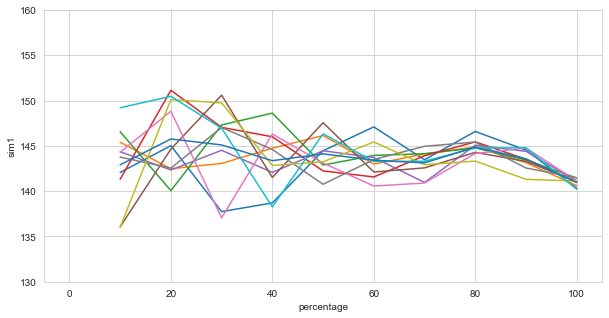

In [233]:
fig, ax = plt.subplots(figsize=(10,5))
for i in df.columns:
    plot = sns.lineplot(x='percentage', y=i, data=df)
    
plot.set_ylim(130,160)

(120.0, 160.0)

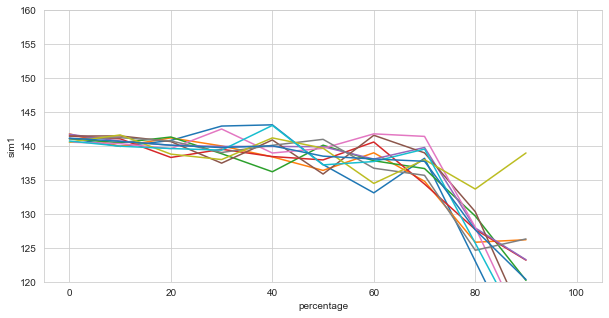

In [192]:
fig, ax = plt.subplots(figsize=(10,5))
for i in ds.columns:
    plot = sns.lineplot(x='percentage', y=i, data=ds)
    
plot.set_ylim(120,160)

In [190]:
ds = pd.DataFrame(d_s)
ds['mean'] = ds.mean(axis=1)
ds['percentage'] = [i for i in np.arange(0,110,10)]
ds

sim1        sim2        sim3        sim4        sim5        sim6  \
100 %  141.108000  141.770000  141.051000  141.461000  141.712000  141.453000   
90 %   139.933333  139.930000  140.463333  141.044444  140.707778  141.468889   
80 %   140.803750  141.180000  141.308750  138.298750  140.082500  140.636250   
70 %   142.920000  139.992857  138.852857  139.508571  139.925714  137.461429   
60 %   143.101667  138.385000  136.195000  138.431667  139.913333  140.873333   
50 %   137.252000  136.394000  140.104000  137.938000  139.882000  135.860000   
40 %   133.092500  138.987500  137.817500  140.572500  138.060000  141.562500   
30 %   138.180000  134.800000  136.666667  134.383333  139.766667  138.976667   
20 %   123.035000  125.825000  129.680000  127.705000  127.925000  130.320000   
10 %   107.850000  126.190000  120.210000  123.190000  123.240000  113.670000   
0 %           NaN         NaN         NaN         NaN         NaN         NaN   

             sim7        sim8        sim9       sim10        mean  percentage  
100 %  140.549000  141.043000  140.549000  140.720000  141.141600           0  
90 %   140.332222  141.204444  141.617778  139.954444  140.665667          10  
80 %   139.600000  140.730000  138.786250  139.612500  140.103875          20  
70 %   142.487143  139.028571  137.990000  139.375714  139.754286          30  
60 %   138.953333  140.090000  141.176667  143.011667  140.013167          40  
50 %   139.638000  140.966000  139.664000  137.206000  138.490400          50  
40 %   141.772500  136.715000  134.480000  137.697500  138.075750          60  
30 %   141.400000  135.670000  137.976667  139.530000  137.735000          70  
20 %   128.020000  124.640000  133.650000  125.690000  127.649000          80  
10 %   112.070000  126.310000  138.960000  111.650000  120.334000          90  
0 %           NaN         NaN         NaN         NaN         NaN         100

In [227]:
d_results['sim1p70'].passengers['waiting_t[sec]'].mean()

19.718

In [255]:
dw = {}

for i in range(1,11):
    d = {}
    for p in range(0,110,10):
        w = d_results['sim{sim_n}p{percentage}'.format(sim_n=i, percentage=p)].passengers['waiting_t[sec]'].mean()
        d["{} %".format(p)] = w
        
    dw["sim{}".format(i)] = d
        
       

In [256]:
dw = pd.DataFrame(dw)
dw['mean'] = dw.mean(axis=1)
dw['percentage'] = [i for i in np.arange(0,110,10)]
dw

sim1    sim2    sim3    sim4    sim5    sim6    sim7    sim8    sim9  \
0 %    19.432  20.408  17.964  20.704  18.504  20.814  21.748  23.582  23.358   
10 %   21.848  22.910  20.012  21.264  17.766  19.354  21.098  18.854  20.080   
20 %   20.884  18.694  20.128  21.462  19.320  18.250  17.632  20.560  20.286   
30 %   24.960  21.534  21.004  17.536  18.562  18.940  22.824  17.690  20.106   
40 %   25.324  20.018  22.070  20.174  20.396  18.938  20.842  24.388  19.502   
50 %   20.812  19.202  20.406  21.718  18.952  19.480  22.792  24.168  19.136   
60 %   20.082  24.434  18.486  21.210  17.472  18.782  23.252  19.662  19.194   
70 %   19.718  18.722  19.168  20.788  20.992  20.724  23.152  16.688  19.162   
80 %   17.700  19.152  22.180  24.032  18.624  18.514  20.454  20.888  20.512   
90 %   21.906  18.566  19.396  22.144  20.194  21.784  20.052  20.362  19.464   
100 %  21.114  21.716  17.980  18.206  19.738  19.186  20.756  20.630  20.462   

        sim10     mean  percentage  
0 %    20.420  20.6934           0  
10 %   20.376  20.3562          10  
20 %   19.668  19.6884          20  
30 %   20.870  20.4026          30  
40 %   20.974  21.2626          40  
50 %   18.362  20.5028          50  
60 %   21.972  20.4546          60  
70 %   16.880  19.5994          70  
80 %   19.834  20.1890          80  
90 %   23.956  20.7824          90  
100 %  20.242  20.0030         100

(0.0, 40.0)

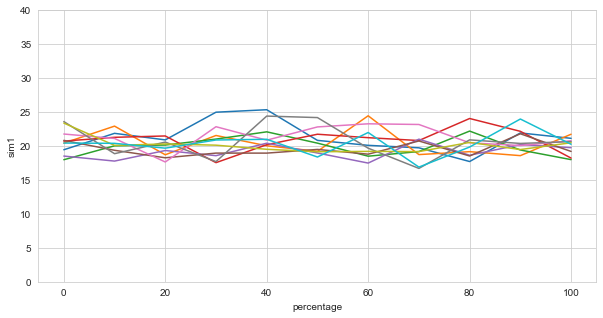

In [252]:
fig, ax = plt.subplots(figsize=(10,5))
a = list(dw.columns)
a.remove('percentage')

for i in a:
    plot = sns.lineplot(x='percentage', y=i, data=dw)
    
plot.set_ylim(0,40)

In [246]:
a = list(dw.columns)

In [249]:
a.remove('percentage')

In [250]:
a

['sim1',
 'sim2',
 'sim3',
 'sim4',
 'sim5',
 'sim6',
 'sim7',
 'sim8',
 'sim9',
 'sim10']

In [280]:
wf

pax_id  veh_id  waiting_t[sec]  number of declines
0         0     1.0             234                   0
1         1    20.0             197                   0
2         2    14.0              68                   0
3         3    17.0              86                   0
4         4     2.0             102                   0
..      ...     ...             ...                 ...
495     495     4.0             270                   0
496     496    20.0             114                   0
497     497    10.0             181                   0
498     498    11.0             250                   0
499     499    15.0             201                   0

[500 rows x 4 columns]

In [278]:
ws = d_results['sim10p0'].passengers
ds = d_results['sim10p0'].trips
ds

veh_id  pax_id  pickup_t[min]  pickup_d[km]  travel_t_with[min]  pax_km  \
0        1       0       3.316667          1.99            3.983333    2.39   
1        1      19       0.650000          0.39            3.166667    1.90   
2        1      31       1.883333          1.13            4.000000    2.40   
3        1      46       3.183333          1.91            3.700000    2.22   
4        1      59       3.850000          2.31            4.900000    2.94   
..     ...     ...            ...           ...                 ...     ...   
20      20     408       5.216667          3.13            5.583333    3.35   
21      20     431       3.983333          2.39            1.916667    1.15   
22      20     452       3.933333          2.36            4.100000    2.46   
23      20     470       5.400000          3.24            4.483333    2.69   
24      20     487       6.083333          3.65            4.200000    2.52   

    travel_t[min]  travel_d[km]  veh_waiting_t[sec]  revenue $  p  sim  
0        7.800000          4.68                   0       4.78  0   10  
1        4.316667          2.59                  63       3.80  0   10  
2        6.383333          3.83                  15       4.80  0   10  
3        7.383333          4.43                  43       4.44  0   10  
4        9.250000          5.55                  10       5.88  0   10  
..            ...           ...                 ...        ... ..  ...  
20      11.300000          6.78                 106       6.70  0   10  
21       6.400000          3.84                  96       2.30  0   10  
22       8.533333          5.12                 239       4.92  0   10  
23      10.383333          6.23                 150       5.38  0   10  
24      10.783333          6.47                  13       5.04  0   10  

[500 rows x 12 columns]

In [279]:
wf = d_results['sim10p100'].passengers
df = d_results['sim10p100'].trips

<AxesSubplot:xlabel='pax_id', ylabel='waiting_t[sec]'>

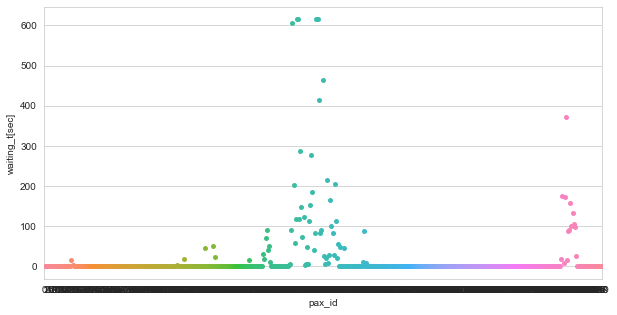

In [264]:
fig, ax = plt.subplots(figsize=(10,5))
sns.swarmplot(x='pax_id', y='waiting_t[sec]', data=ws)

<AxesSubplot:xlabel='pax_id', ylabel='waiting_t[sec]'>

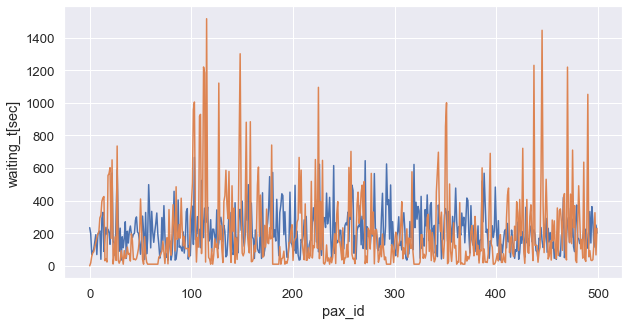

In [282]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x='pax_id', y='waiting_t[sec]', data=wf)
sns.lineplot(x='pax_id', y='veh_waiting_t[sec]', data=df)

<AxesSubplot:xlabel='waiting_t[sec]', ylabel='Density'>

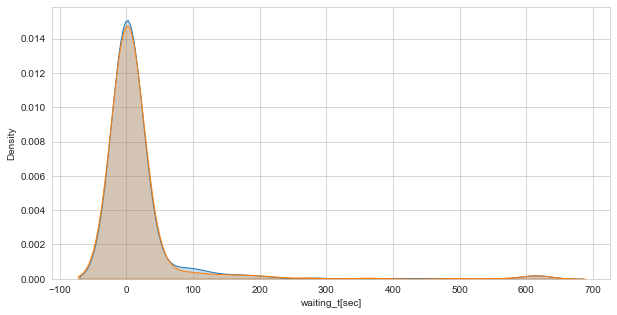

In [268]:
fig, ax = plt.subplots(figsize=(10,5))
sns.kdeplot(x='waiting_t[sec]', data=ws, shade=True)
sns.kdeplot(x='waiting_t[sec]', data=wf, shade=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.swarmplot(x='pax_id', y='waiting_t[sec]', data=ws)

In [273]:
d_results['sim10p100'].requests

veh_id  n_of_requests  n_of_accepted  n_of_declined  acceptance_rate %
0       1             32             24              8          75.000000
1       2             31             26              5          83.870968
2       3             32             24              8          75.000000
3       4             32             25              7          78.125000
4       5             25             20              5          80.000000
5       6             32             25              7          78.125000
6       7             39             29             10          74.358974
7       8             29             25              4          86.206897
8       9             28             24              4          85.714286
9      10             39             28             11          71.794872
10     11             31             26              5          83.870968
11     12             31             26              5          83.870968
12     13             38             27             11          71.052632
13     14             31             25              6          80.645161
14     15             35             28              7          80.000000
15     16             23             19              4          82.608696
16     17             28             25              3          89.285714
17     18             31             26              5          83.870968
18     19             25             21              4          84.000000
19     20             34             21             13          61.764706

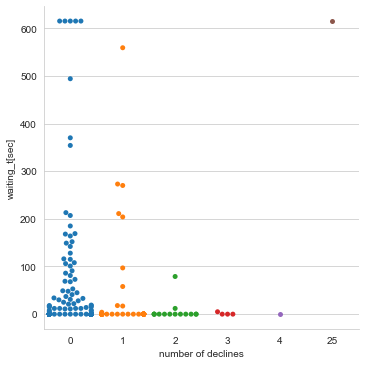

In [271]:
sns.catplot(x='number of declines', y='waiting_t[sec]', data=wf, kind='swarm')

(60.0, 100.0)

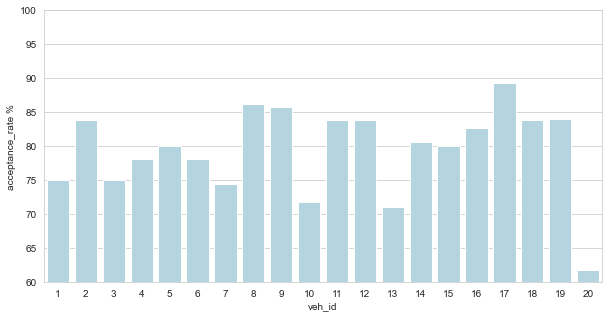

In [285]:
af = d_results['sim10p100'].requests

fig, ax = plt.subplots(figsize=(10,5))

g = sns.barplot(x='veh_id', y='acceptance_rate %', data=af, color='lightblue')
g.set_ylim(60,100)

<AxesSubplot:xlabel='acceptance_rate %', ylabel='revenue $'>

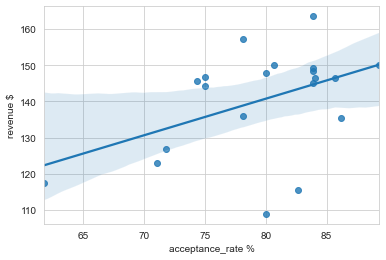

In [289]:
sns.regplot(x=d_results['sim10p100'].requests['acceptance_rate %'],
            y=d_results['sim10p100'].trips.groupby(['veh_id']).sum()['revenue $'])

In [198]:
df = df.join(fd['acceptance_rate %'])
df

veh_id  pax_id  pickup_t[min]  pickup_d[km]  travel_t_with[min]  pax_km  \
0         1    6607      78.583333         47.15          136.683333   82.01   
1         2    5871      80.316667         48.19          111.950000   67.17   
2         3    5435      86.283333         51.77           97.800000   58.68   
3         4    7229      73.266667         43.96          123.933333   74.36   
4         5    6209      71.450000         42.87          106.583333   63.95   
..      ...     ...            ...           ...                 ...     ...   
195      16    6281      70.500000         42.30          122.050000   73.23   
196      17    5961      70.000000         42.00          119.883333   71.93   
197      18    5126      64.250000         38.55          125.366667   75.22   
198      19    5973      71.200000         42.72          109.066667   65.44   
199      20    6788      67.800000         40.68          145.000000   87.00   

     travel_t[min]  travel_d[km]  veh_waiting_t[sec]  revenue $  \
0       228.766667        137.26                3688     164.02   
1       204.933333        122.96                5170     134.34   
2       194.816667        116.89                6110     117.36   
3       210.700000        126.42                4675     148.72   
4       190.750000        114.45                5771     127.90   
..             ...           ...                 ...        ...   
195     204.550000        122.73                4925     146.46   
196     202.416667        121.45                5203     143.86   
197     201.466667        120.88                5261     150.44   
198     192.266667        115.36                5758     130.88   
199     226.900000        136.14                3898     174.00   

     acceptance_rate %  
0            79.411765  
1            83.333333  
2            60.000000  
3            84.375000  
4            71.428571  
..                 ...  
195          72.727273  
196          75.757576  
197          76.666667  
198          68.571429  
199          77.777778  

[200 rows x 11 columns]

In [213]:
s1 = df[df['acceptance_rate %']>65]; s1 = df[df['acceptance_rate %']<80]
s1

veh_id  pax_id  pickup_t[min]  pickup_d[km]  travel_t_with[min]  pax_km  \
0         1    6607      78.583333         47.15          136.683333   82.01   
2         3    5435      86.283333         51.77           97.800000   58.68   
4         5    6209      71.450000         42.87          106.583333   63.95   
5         6    5862      72.316667         43.39          133.300000   79.98   
6         7    5819      79.866667         47.92          117.883333   70.73   
..      ...     ...            ...           ...                 ...     ...   
195      16    6281      70.500000         42.30          122.050000   73.23   
196      17    5961      70.000000         42.00          119.883333   71.93   
197      18    5126      64.250000         38.55          125.366667   75.22   
198      19    5973      71.200000         42.72          109.066667   65.44   
199      20    6788      67.800000         40.68          145.000000   87.00   

     travel_t[min]  travel_d[km]  veh_waiting_t[sec]  revenue $  \
0       228.766667        137.26                3688     164.02   
2       194.816667        116.89                6110     117.36   
4       190.750000        114.45                5771     127.90   
5       217.116667        130.27                4316     159.96   
6       209.750000        125.85                5232     141.46   
..             ...           ...                 ...        ...   
195     204.550000        122.73                4925     146.46   
196     202.416667        121.45                5203     143.86   
197     201.466667        120.88                5261     150.44   
198     192.266667        115.36                5758     130.88   
199     226.900000        136.14                3898     174.00   

     acceptance_rate %  
0            79.411765  
2            60.000000  
4            71.428571  
5            71.875000  
6            77.419355  
..                 ...  
195          72.727273  
196          75.757576  
197          76.666667  
198          68.571429  
199          77.777778  

[154 rows x 11 columns]

<AxesSubplot:xlabel='acceptance_rate %', ylabel='revenue $'>

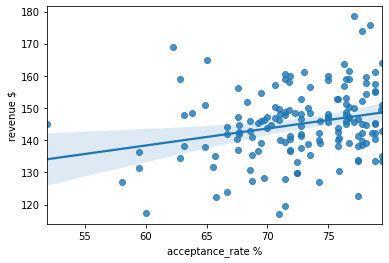

In [214]:
sns.regplot(x=s1['acceptance_rate %'], y=s1['revenue $'])

In [ ]:
first_half = r_5050.trips.groupby(['veh_id']).sum().iloc[0:int(params.nV*p/100)].sum()['revenue $']/int(params.nV*p/100)
second_half = r_5050.trips.groupby(['veh_id']).sum().iloc[int(params.nV*p/100):int(params.nV)].sum()['revenue $']/int(round(params.nV*(1-p/100)))      
df["{} %".format(p)] = first_half
ds["{} %".format(100-p)] = second_half

d_f["sim{}".format(i)] = df
d_s["sim{}".format(i)] = ds
